In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from datetime import timedelta
from datetime import datetime
from datetime import date
from datetime import time

from tqdm import tqdm
import scipy.stats as st

In [2]:
df_transf0 = pd.read_csv("DATA_RESULTS/df_RBCT_extractedFeat_NoImputated_tau9_v3.csv")
df_transf0.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
# df_RBCT_extractedFeat_medImputated_tau9_v3
# df_RBCT_extractedFeat_NoImputated_tau9_v3.csv

In [3]:
df_transf0.drop_duplicates(inplace=True)
df_transf0.shape

(22874, 49)

# Eliminated the patients having pre-transfusion SF, Hb, SpO2, PF missing

In [5]:
print(df_transf0[['med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT','med_PF_beforeT']].isnull().all(axis=1).sum())

df_transf = df_transf0[~df_transf0[['med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT','med_PF_beforeT']].isnull().all(axis=1)]
df_transf.reset_index(drop=True, inplace=True)
print(df_transf.shape)

print(len(df_transf0.pat_id.unique()), len(df_transf0.csn.unique()), len(df_transf.pat_id.unique()), len(df_transf.csn.unique()))

7
(22867, 49)
13051 14765 13045 14758


In [ ]:
df_transf

In [37]:
df_transf[df_transf.med_spo2_beforeT.isnull()].shape

(110, 49)

In [38]:
df_transf.med_SF_beforeT.isnull().sum()

4151

In [39]:
df_transf.columns

Index(['pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3',
       'del_Hb_1', 'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3',
       'del_PF_1', 'del_PF_2', 'del_PF_3'],
      dtype='object')

In [40]:
df_transf.loc[:,'Hb':].max()

Hb                    19.800000
med_spo2_beforeT     100.000000
med_Hb_beforeT        19.400000
med_SF_beforeT       476.190476
med_PF_beforeT      2366.666667
MSPO2_afterT1        100.000000
MSPO2_afterT2        100.000000
MSPO2_afterT3        100.000000
MHB_afterT1           17.400000
MHB_afterT2           17.400000
MHB_afterT3           17.300000
MSF_afterT1          476.190476
MSF_afterT2          476.190476
MSF_afterT3          476.190476
MPF_afterT1         2371.428571
MPF_afterT2         2371.428571
MPF_afterT3         2371.428571
del_SPO2_1            93.000000
del_SPO2_2            92.000000
del_SPO2_3            92.000000
del_Hb_1              10.600000
del_Hb_2              10.700000
del_Hb_3              10.300000
del_SF_1             376.190476
del_SF_2             378.190476
del_SF_3             376.190476
del_PF_1            1344.583333
del_PF_2            1383.333333
del_PF_3            1383.333333
dtype: float64

In [41]:
df_transf['MSF_beforeT']=df_transf['med_SF_beforeT']
# df_transf.pop('med_SF_beforeT')
df_transf['MSF_beforeT']

/tmp/ipykernel_5709/2981157439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['MSF_beforeT']=df_transf['med_SF_beforeT']


0        476.190476
1        461.904762
2        466.666667
3        285.714286
4        147.063492
            ...    
22862    466.666667
22863    323.750000
22864     99.000000
22865    476.190476
22866    350.000000
Name: MSF_beforeT, Length: 22867, dtype: float64

In [42]:
df_transf['MSF_beforeT'].isnull().sum()

4151

In [43]:
(df_transf[['MSF_beforeT','MSF_afterT1']].T.isnull().sum()==2).sum()

3842

## Delta SF vs baseline Hb for 4 pre-SF ranges and 3 time-horizons

In [44]:
cond1 =  df_transf['MSF_beforeT']>0 
cond2 = df_transf['MSF_beforeT']<=100
cond12 = cond1 & cond2
# MSFbaseline_gp1 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp1 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [45]:
# MSFbaseline_gp2[~MSFbaseline_gp2.isnull()]
cond12.shape, MSFbaseline_gp1.shape

((22867,), (22867,))

In [46]:
MSFbaseline_gp1.isnull().sum()

21564

In [47]:
del cond1, cond2, cond12

In [48]:
cond1 =  df_transf['MSF_beforeT']>100 
cond2 = df_transf['MSF_beforeT']<=200
cond12 = cond1 & cond2
# MSFbaseline_gp2 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp2 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [49]:
del cond1, cond2, cond12
cond1 =  df_transf['MSF_beforeT']>200 
cond2 = df_transf['MSF_beforeT']<=300
cond12 = cond1 & cond2
# MSFbaseline_gp3 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp3 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [50]:
del cond1, cond2, cond12
cond12 =  df_transf['MSF_beforeT']>300 
# MSFbaseline_gp4 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp4 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [51]:
# df_transf['MSF_afterT1']#
zx = df_transf['MSF_afterT1'] - MSFbaseline_gp1
zx.isnull().sum()

21705

In [52]:
(~MSFbaseline_gp1.isnull()).sum() + (~MSFbaseline_gp2.isnull()).sum() +(~MSFbaseline_gp3.isnull()).sum()+(~MSFbaseline_gp4.isnull()).sum()

18716

In [53]:
len(df_transf['MSF_afterT1'])

22867

In [54]:
len(MSFbaseline_gp1)

22867

In [55]:
zx

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
22862    NaN
22863    NaN
22864   -2.0
22865    NaN
22866    NaN
Length: 22867, dtype: object

In [56]:
df_transf['del_SF_1a']=df_transf['MSF_afterT1'] - MSFbaseline_gp1
df_transf['del_SF_2a']=df_transf['MSF_afterT2'] - MSFbaseline_gp1
df_transf['del_SF_3a']=df_transf['MSF_afterT3'] - MSFbaseline_gp1

/tmp/ipykernel_5709/1527135969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1a']=df_transf['MSF_afterT1'] - MSFbaseline_gp1
/tmp/ipykernel_5709/1527135969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2a']=df_transf['MSF_afterT2'] - MSFbaseline_gp1
/tmp/ipykernel_5709/1527135969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [57]:
# aa = df_transf['del_SF_1a']
# bb = aa[~np.isnan(aa)]
# cc = (np.array(aa[bb.index]))

# aa1 = df_transf['Hb']
# cc1 = (np.array(aa1[bb.index]))

# print(len(cc))
# print(len(cc1))
# plt.scatter(cc, cc1,color='black')

In [58]:
df_transf['del_SF_1b']=df_transf['MSF_afterT1'] - MSFbaseline_gp2
df_transf['del_SF_2b']=df_transf['MSF_afterT2'] - MSFbaseline_gp2
df_transf['del_SF_3b']=df_transf['MSF_afterT3'] - MSFbaseline_gp2

/tmp/ipykernel_5709/3867128395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1b']=df_transf['MSF_afterT1'] - MSFbaseline_gp2
/tmp/ipykernel_5709/3867128395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2b']=df_transf['MSF_afterT2'] - MSFbaseline_gp2
/tmp/ipykernel_5709/3867128395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [59]:
df_transf['del_SF_1c']=df_transf['MSF_afterT1'] - MSFbaseline_gp3
df_transf['del_SF_2c']=df_transf['MSF_afterT2'] - MSFbaseline_gp3
df_transf['del_SF_3c']=df_transf['MSF_afterT3'] - MSFbaseline_gp3

/tmp/ipykernel_5709/942912688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1c']=df_transf['MSF_afterT1'] - MSFbaseline_gp3
/tmp/ipykernel_5709/942912688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2c']=df_transf['MSF_afterT2'] - MSFbaseline_gp3
/tmp/ipykernel_5709/942912688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [60]:
df_transf['del_SF_1d']=df_transf['MSF_afterT1'] - MSFbaseline_gp4
df_transf['del_SF_2d']=df_transf['MSF_afterT2'] - MSFbaseline_gp4
df_transf['del_SF_3d']=df_transf['MSF_afterT3'] - MSFbaseline_gp4

/tmp/ipykernel_5709/3766971520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1d']=df_transf['MSF_afterT1'] - MSFbaseline_gp4
/tmp/ipykernel_5709/3766971520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2d']=df_transf['MSF_afterT2'] - MSFbaseline_gp4
/tmp/ipykernel_5709/3766971520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [61]:
MSFbaseline_gp1

0        None
1        None
2        None
3        None
4        None
         ... 
22862    None
22863    None
22864    99.0
22865    None
22866    None
Length: 22867, dtype: object

In [62]:
df_transf[['del_SF_1a', 'MSF_afterT1']]

,del_SF_1a,MSF_afterT1
0,NaN,476.190476
1,NaN,459.523810
2,NaN,466.666667
3,NaN,285.714286
4,NaN,235.000000
...,...,...
22862,NaN,466.666667
22863,NaN,152.500000
22864,-2.0,97.000000
22865,NaN,476.190476


(-400.0, 400.0)

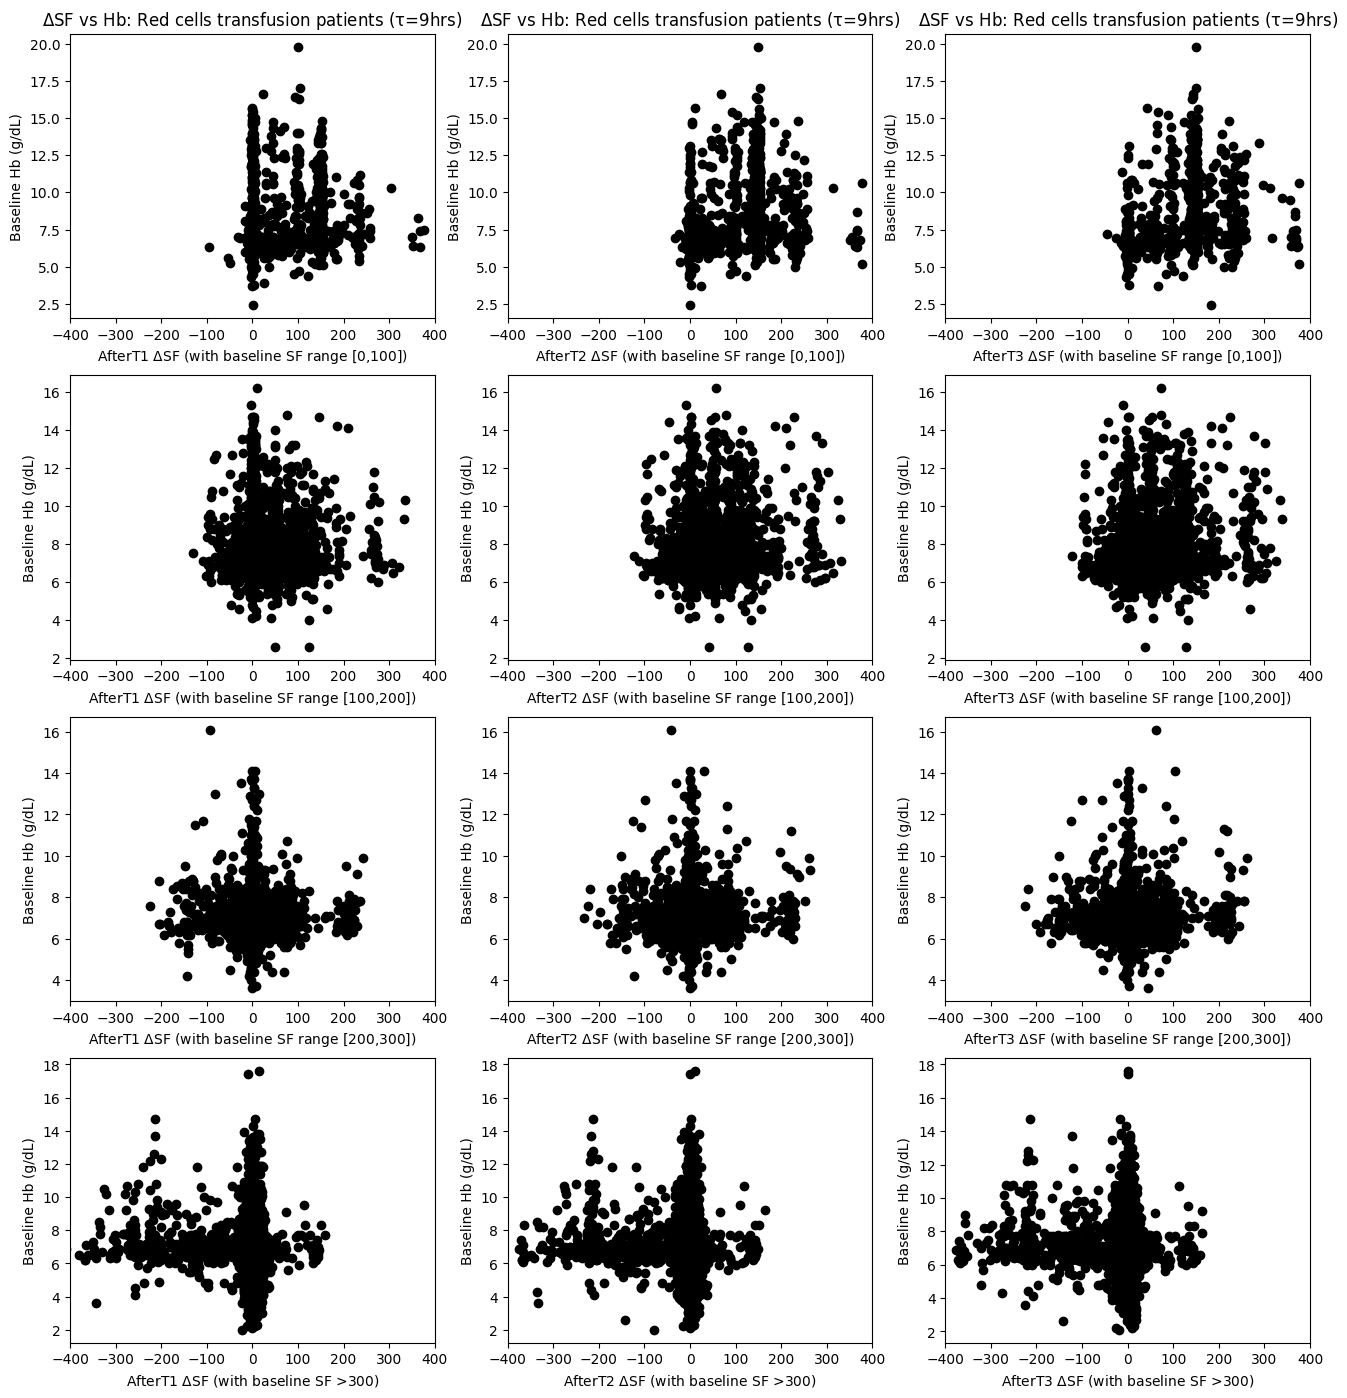

In [64]:
fig, axs = plt.subplots(4, 3, figsize =(16, 17))

axs[0,0].scatter(df_transf['del_SF_1a'], df_transf['Hb'],color='black')
axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [0,100])')
axs[0,0].set_ylabel('Baseline Hb (g/dL)')
axs[0,0].set_xlim([-400, 400])

axs[0,1].scatter(df_transf['del_SF_2a'], df_transf['Hb'],color='black')
axs[0,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [0,100])')
axs[0,1].set_ylabel('Baseline Hb (g/dL)')
axs[0,1].set_xlim([-400, 400])

axs[0,2].scatter(df_transf['del_SF_3a'], df_transf['Hb'],color='black')
axs[0,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [0,100])')
axs[0,2].set_ylabel('Baseline Hb (g/dL)')
axs[0,2].set_xlim([-400, 400])

axs[1,0].scatter(df_transf['del_SF_1b'], df_transf['Hb'],color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [100,200])')
axs[1,0].set_ylabel('Baseline Hb (g/dL)')
axs[1,0].set_xlim([-400, 400])

axs[1,1].scatter(df_transf['del_SF_2b'], df_transf['Hb'],color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [100,200])')
axs[1,1].set_ylabel('Baseline Hb (g/dL)')
axs[1,1].set_xlim([-400, 400])

axs[1,2].scatter(df_transf['del_SF_3b'], df_transf['Hb'],color='black')
#axs[1,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [100,200])')
axs[1,2].set_ylabel('Baseline Hb (g/dL)')
axs[1,2].set_xlim([-400, 400])

axs[2,0].scatter(df_transf['del_SF_1c'], df_transf['Hb'],color='black')
#axs[2,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [200,300])')
axs[2,0].set_ylabel('Baseline Hb (g/dL)')
axs[2,0].set_xlim([-400, 400])

axs[2,1].scatter(df_transf['del_SF_2c'], df_transf['Hb'],color='black')
#axs[2,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [200,300])')
axs[2,1].set_ylabel('Baseline Hb (g/dL)')
axs[2,1].set_xlim([-400, 400])

axs[2,2].scatter(df_transf['del_SF_3c'], df_transf['Hb'],color='black')
#axs[2,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [200,300])')
axs[2,2].set_ylabel('Baseline Hb (g/dL)')
axs[2,2].set_xlim([-400, 400])

axs[3,0].scatter(df_transf['del_SF_1d'], df_transf['Hb'],color='black')
#axs[3,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF >300)')
axs[3,0].set_ylabel('Baseline Hb (g/dL)')
axs[3,0].set_xlim([-400, 400])

axs[3,1].scatter(df_transf['del_SF_2d'], df_transf['Hb'],color='black')
#axs[3,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF >300)')
axs[3,1].set_ylabel('Baseline Hb (g/dL)')
axs[3,1].set_xlim([-400, 400])

axs[3,2].scatter(df_transf['del_SF_3d'], df_transf['Hb'],color='black')
#axs[3,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF >300)')
axs[3,2].set_ylabel('Baseline Hb (g/dL)')
axs[3,2].set_xlim([-400, 400])

# plt.savefig('DATA_RESULTS/delSFvsHb_RedCellsT.png',format="png", bbox_inches="tight", dpi=300)

**Analysis: (1) % improvement in SF (for baseline SF 1-100 and >300) with 95% CI, (b) Association b/w Hb vs delSF**

In [65]:
#for baseline SF 1-100
dSF1a = df_transf['del_SF_1a'][~df_transf['del_SF_1a'].isnull()]
dSF2a = df_transf['del_SF_2a'][~df_transf['del_SF_2a'].isnull()]
dSF3a = df_transf['del_SF_3a'][~df_transf['del_SF_3a'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1a = st.t.interval(0.95, len(dSF1a)-1, loc=dSF1a.mean(), scale=st.sem(dSF1a, nan_policy='omit'))
CI2a = st.t.interval(0.95, len(dSF2a)-1, loc=dSF2a.mean(), scale=st.sem(dSF2a, nan_policy='omit'))
CI3a = st.t.interval(0.95, len(dSF3a)-1, loc=dSF3a.mean(), scale=st.sem(dSF3a, nan_policy='omit'))
print(f'For baseline SF (1-100), mean increase in SF for T1 with 95% CI: ',dSF1a.mean(),CI1a)
print(f'For baseline SF (1-100), mean increase in SF for T2 with 95% CI: ',dSF2a.mean(),CI2a)
print(f'For baseline SF (1-100), mean increase in SF for T3 with 95% CI: ',dSF3a.mean(),CI3a)

For baseline SF (1-100), mean increase in SF for T1 with 95% CI:  75.88085020580745 (71.39763972557797, 80.36406068603692)
For baseline SF (1-100), mean increase in SF for T2 with 95% CI:  107.26598696240148 (102.69567172144653, 111.83630220335644)
For baseline SF (1-100), mean increase in SF for T3 with 95% CI:  123.0093067334429 (118.4231524468507, 127.5954610200351)


In [66]:
dSF1a

12        -0.166667
58       236.222222
70       155.166667
80              0.5
103      107.666667
            ...    
22739         146.0
22774       149.125
22794           0.5
22828    147.416667
22864          -2.0
Name: del_SF_1a, Length: 1162, dtype: object

In [67]:
#for baseline SF 101-200
dSF1b = df_transf['del_SF_1b'][~df_transf['del_SF_1b'].isnull()]
dSF2b = df_transf['del_SF_2b'][~df_transf['del_SF_2b'].isnull()]
dSF3b = df_transf['del_SF_3b'][~df_transf['del_SF_3b'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1b = st.t.interval(0.95, len(dSF1b)-1, loc=dSF1b.mean(), scale=st.sem(dSF1b, nan_policy='omit'))
CI2b = st.t.interval(0.95, len(dSF2b)-1, loc=dSF2b.mean(), scale=st.sem(dSF2b, nan_policy='omit'))
CI3b = st.t.interval(0.95, len(dSF3b)-1, loc=dSF2b.mean(), scale=st.sem(dSF3b, nan_policy='omit'))

In [68]:
#for baseline SF 201-300
dSF1c = df_transf['del_SF_1c'][~df_transf['del_SF_1c'].isnull()]
dSF2c = df_transf['del_SF_2c'][~df_transf['del_SF_2c'].isnull()]
dSF3c = df_transf['del_SF_3c'][~df_transf['del_SF_3c'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1c = st.t.interval(0.95, len(dSF1c)-1, loc=dSF1c.mean(), scale=st.sem(dSF1c, nan_policy='omit'))
CI2c = st.t.interval(0.95, len(dSF2c)-1, loc=dSF2c.mean(), scale=st.sem(dSF2c, nan_policy='omit'))
CI3c = st.t.interval(0.95, len(dSF3c)-1, loc=dSF2c.mean(), scale=st.sem(dSF3c, nan_policy='omit'))

In [69]:
#for baseline SF >300
dSF1d = df_transf['del_SF_1d'][~df_transf['del_SF_1d'].isnull()]
dSF2d = df_transf['del_SF_2d'][~df_transf['del_SF_2d'].isnull()]
dSF3d = df_transf['del_SF_3d'][~df_transf['del_SF_3d'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1d = st.t.interval(0.95, len(dSF1d)-1, loc=dSF1d.mean(), scale=st.sem(dSF1d, nan_policy='omit'))
CI2d = st.t.interval(0.95, len(dSF2d)-1, loc=dSF2d.mean(), scale=st.sem(dSF2d, nan_policy='omit'))
CI3d = st.t.interval(0.95, len(dSF3d)-1, loc=dSF2d.mean(), scale=st.sem(dSF3d, nan_policy='omit'))
print(f'For baseline SF>300, mean increase in SF for T1 with 95% CI: ',dSF1d.mean(),CI1d)
print(f'For baseline SF>300, mean increase in SF for T2 with 95% CI: ',dSF2d.mean(),CI2d)
print(f'For baseline SF>300, mean increase in SF for T3 with 95% CI: ',dSF3d.mean(),CI3d)

For baseline SF>300, mean increase in SF for T1 with 95% CI:  -5.902770523937168 (-6.592909028574938, -5.212632019299398)
For baseline SF>300, mean increase in SF for T2 with 95% CI:  -7.307205859386075 (-8.056819896164276, -6.557591822607874)
For baseline SF>300, mean increase in SF for T3 with 95% CI:  -8.440499735087293 (-8.130190807636613, -6.484220911135537)


In [70]:
df_transf['del_SF_1d'].max()

160.34226190476193

In [71]:
a1 = np.array([1,2,3,np.nan, np.nan,5])
a2 = np.array([9,np.nan,8,np.nan, np.nan,np.nan])

In [72]:
cond = ~np.isnan(a1+a2)
a1 = a1[cond]
a2 = a2[cond]
a1, a2

(array([1., 3.]), array([9., 8.]))

In [73]:
a1

array([1., 3.])

In [74]:
from sklearn.metrics import r2_score

In [75]:
def r2Score(y, f): #y:actual, f:predicted
    # SSres = sum(map(lambda x: (x[0]-x[1])**2, zip(y, f)))
    # SStot = sum([(x-np.mean(y))**2 for x in y])
    # r2 = 1-(SSres/SStot)
    
    cond = ~np.isnan(np.array(y+f, dtype='float'))
    y = y[cond]
    f = f[cond]
    
    
    ssres = sum((y - f)**2)
    sstot = sum((y-np.mean(y))**2)
    r2 = 1-(ssres/sstot)
    
    return r2

In [76]:
#R2 (R2 = 1- SSres/SStotal) of delta SF vs baseline Hb 
id1a = np.array(dSF1a.index)
mdSF1a = np.array(dSF1a)    #[~np.isnan(MSFbaseline_gp1)]
mHb1a = np.array(df_transf['Hb'][id1a])
r2_1a = r2Score(mdSF1a, mHb1a)

id2a = np.array(dSF2a.index)
mdSF2a = np.array(dSF2a)    
mHb2a = np.array(df_transf['Hb'][id2a])
r2_2a = r2Score(mdSF2a, mHb2a)

id3a = np.array(dSF3a.index)
mdSF3a = np.array(dSF3a)    
mHb3a = np.array(df_transf['Hb'][id3a])
r2_3a = r2Score(mdSF3a, mHb3a)


print('r2 score for mdSF1a, mHb1a is', r2_1a)
print('r2 score for mdSF2a, mHb2a is', r2_2a)
print('r2 score for mdSF3a, mHb3a is', r2_3a)

r2 score for mdSF1a, mHb1a is -0.6811735552510243
r2 score for mdSF2a, mHb2a is -1.4066151893863088
r2 score for mdSF3a, mHb3a is -1.9974520491654952


In [77]:
# print(r2_score(mdSF1a, mHb1a))
# print(r2_score(mdSF2a, mHb2a))
# print(r2_score(mdSF3a, mHb3a))

In [78]:
id1b = np.array(dSF1b.index)
mHb1b = np.array(df_transf['Hb'][id1b])
id2b = np.array(dSF2b.index)
mHb2b = np.array(df_transf['Hb'][id2b])
id3b = np.array(dSF3b.index)
mHb3b = np.array(df_transf['Hb'][id3b])

id1c = np.array(dSF1c.index)
mHb1c = np.array(df_transf['Hb'][id1c])
id2c = np.array(dSF2c.index)
mHb2c = np.array(df_transf['Hb'][id2c])
id3c = np.array(dSF3c.index)
mHb3c = np.array(df_transf['Hb'][id3c])

In [79]:
#R2 (R2 = 1- SSres/SStotal) of delta SF vs baseline Hb 
id1d = np.array(dSF1d.index)
mdSF1d = np.array(dSF1d)    #[~np.isnan(MSFbaseline_gp1)]
mHb1d = np.array(df_transf['Hb'][id1d])
r2_1d = r2Score(mdSF1d, mHb1d)

id2d = np.array(dSF2d.index)
mdSF2d = np.array(dSF2d)    
mHb2d = np.array(df_transf['Hb'][id2d])
r2_2d = r2Score(mdSF2d, mHb2d)

id3d = np.array(dSF3d.index)
mdSF3d = np.array(dSF3d)    
mHb3d = np.array(df_transf['Hb'][id3d])
r2_3d = r2Score(mdSF3d, mHb3d)


print('r2 score for mdSF1d, mHb1d is', r2_1d)
print('r2 score for mdSF2d, mHb2d is', r2_2d)
print('r2 score for mdSF3d, mHb3d is', r2_3d)

r2 score for mdSF1d, mHb1d is -0.13296866452440392
r2 score for mdSF2d, mHb2d is -0.14227342744319027
r2 score for mdSF3d, mHb3d is -0.14507903506099273


In [80]:
df_transf['Hb'].max()


19.8

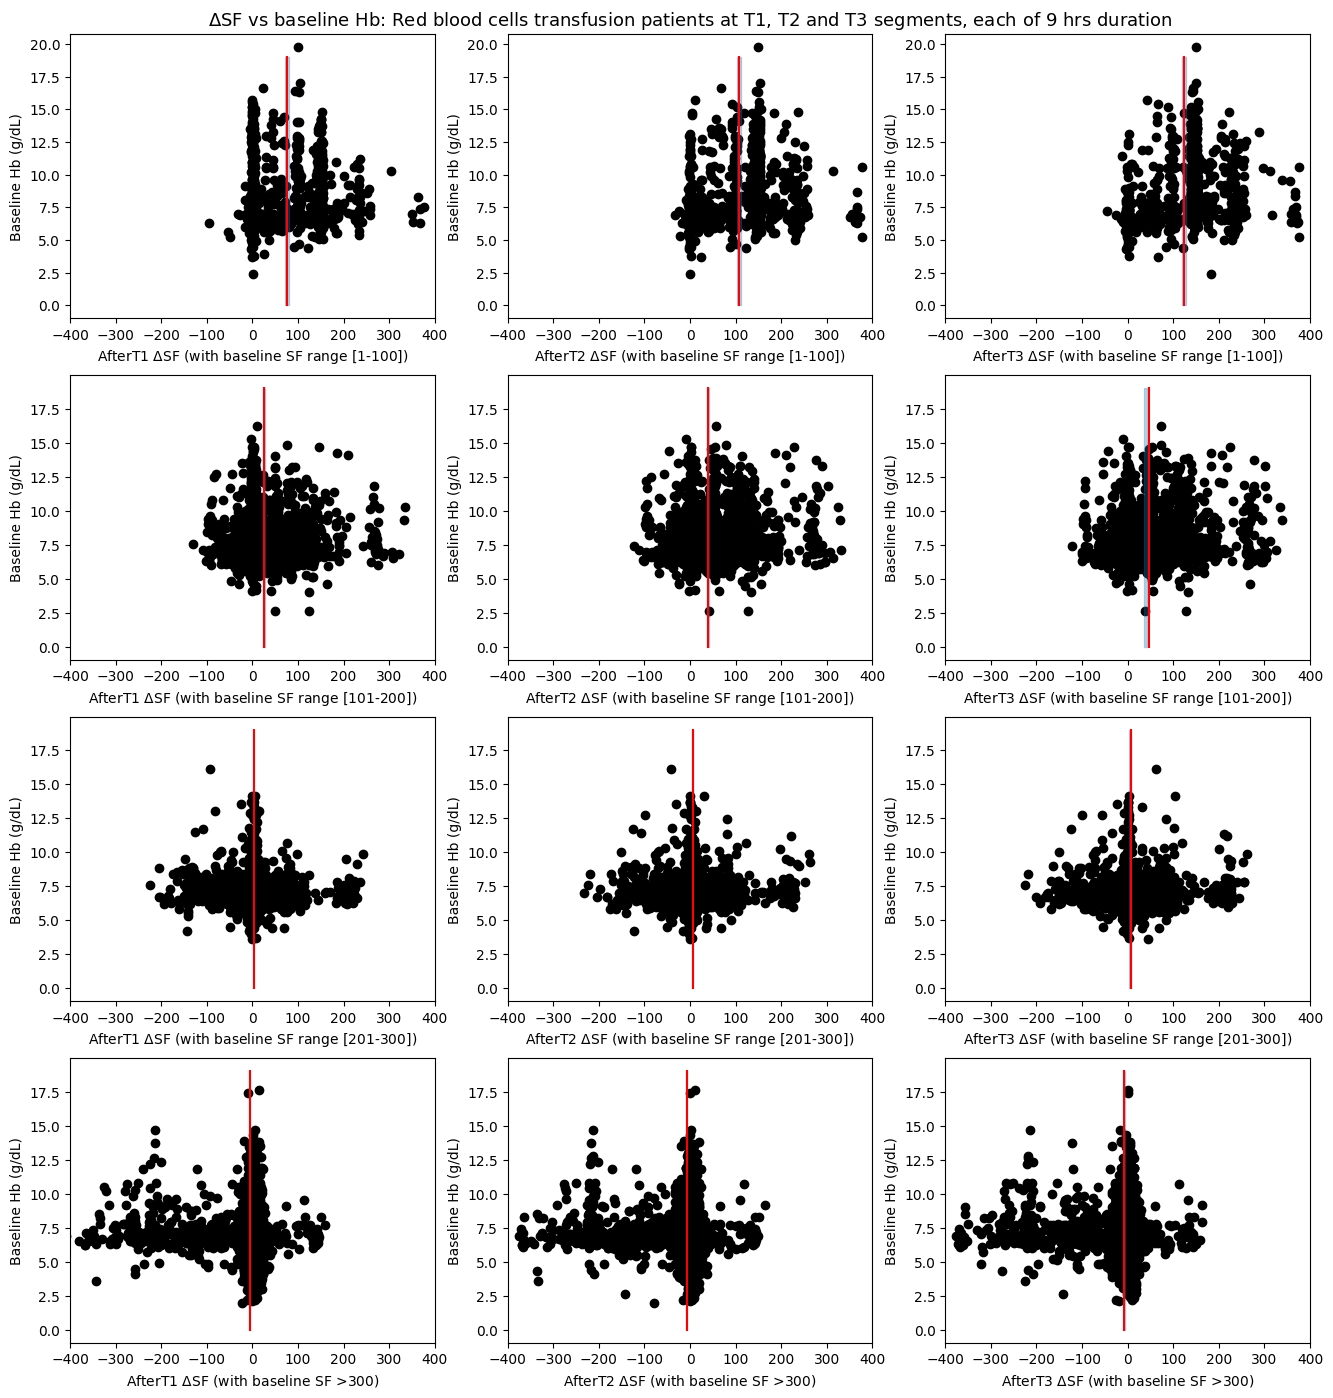

In [81]:
fig, axs = plt.subplots(4, 3, figsize =(16, 17))
line1 = np.arange(20)

axs[0,0].scatter(df_transf['del_SF_1a'], df_transf['Hb'],color='black')
#axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [1-100])')
axs[0,0].set_ylabel('Baseline Hb (g/dL)')
axs[0,0].set_xlim([-400, 400])
# axs[0,0].set_ylim([df_transf['Hb'].min()-0.5, df_transf['Hb'].max()+0.5])
axs[0,0].plot(np.mean(dSF1a)*np.ones(20), line1,color='red')
axs[0,0].fill_betweenx(line1, CI1a[0], CI1a[1], color='C0', alpha=0.3)


axs[0,1].scatter(df_transf['del_SF_2a'], df_transf['Hb'],color='black')
axs[0,1].set_title('$\Delta$SF vs baseline Hb: Red blood cells transfusion patients at T1, T2 and T3 segments, each of 9 hrs duration', fontsize = 13)#\u03C4=9hrs
axs[0,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [1-100])')
axs[0,1].set_ylabel('Baseline Hb (g/dL)')
axs[0,1].set_xlim([-400, 400])
# axs[0,1].set_ylim([np.min(mHb2a)-0.5, np.max(mHb2a)+0.5])
axs[0,1].plot(np.mean(dSF2a)*np.ones(20), line1,color='red')
#axs[0,1].plot(CI2a[0]*np.ones(20), line1,'g:',CI2a[1]*np.ones(20), line1,'g:')
axs[0,1].fill_betweenx(line1, CI2a[0], CI2a[1], color='C0', alpha=0.3)


axs[0,2].scatter(df_transf['del_SF_3a'], df_transf['Hb'],color='black')
#axs[0,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [1-100])')
axs[0,2].set_ylabel('Baseline Hb (g/dL)')
axs[0,2].set_xlim([-400, 400])
# axs[0,2].set_ylim([np.min(mHb3a)-0.5, np.max(mHb3a)+0.5])
axs[0,2].plot(np.mean(dSF3a)*np.ones(20), line1,color='red')
#axs[0,2].plot(CI3a[0]*np.ones(20), line1,'g:',CI3a[1]*np.ones(20), line1,'g:')
axs[0,2].fill_betweenx(line1, CI3a[0], CI3a[1], color='C0', alpha=0.3)


#----------------------------------------------------------------------------
axs[1,0].scatter(df_transf['del_SF_1b'], df_transf['Hb'],color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [101-200])')
axs[1,0].set_ylabel('Baseline Hb (g/dL)')
axs[1,0].set_xlim([-400, 400])
# axs[1,0].set_ylim([np.min(mHb1b)-0.5, np.max(mHb1b)+0.5])
axs[1,0].plot(np.mean(dSF1b)*np.ones(20), line1,color='red')
axs[1,0].fill_betweenx(line1, CI1b[0], CI1b[1], color='C0', alpha=0.3)


axs[1,1].scatter(df_transf['del_SF_2b'], df_transf['Hb'],color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [101-200])')
axs[1,1].set_ylabel('Baseline Hb (g/dL)')
axs[1,1].set_xlim([-400, 400])
# axs[1,1].set_ylim([np.min(mHb2b)-0.5, np.max(mHb2b)+0.5])
axs[1,1].plot(np.mean(dSF2b)*np.ones(20), line1,color='red')
axs[1,1].fill_betweenx(line1, CI2b[0], CI2b[1], color='C0', alpha=0.3)


axs[1,2].scatter(df_transf['del_SF_3b'], df_transf['Hb'],color='black')
#axs[1,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [101-200])')
axs[1,2].set_ylabel('Baseline Hb (g/dL)')
axs[1,2].set_xlim([-400, 400])
# axs[1,2].set_ylim([np.min(mHb3b)-0.5, np.max(mHb3b)+0.5])
axs[1,2].plot(np.mean(dSF3b)*np.ones(20), line1,color='red')
axs[1,2].fill_betweenx(line1, CI3b[0], CI3b[1], color='C0', alpha=0.3)

##--------------------------------------------------------------------
axs[2,0].scatter(df_transf['del_SF_1c'], df_transf['Hb'],color='black')
#axs[2,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [201-300])')
axs[2,0].set_ylabel('Baseline Hb (g/dL)')
axs[2,0].set_xlim([-400, 400])
# axs[2,0].set_ylim([np.min(mHb1c)-0.5, np.max(mHb1c)+0.5])
axs[2,0].plot(np.mean(dSF1c)*np.ones(20), line1,color='red')
axs[2,0].fill_betweenx(line1, CI1c[0], CI1c[1], color='C0', alpha=0.3)


axs[2,1].scatter(df_transf['del_SF_2c'], df_transf['Hb'],color='black')
#axs[2,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [201-300])')
axs[2,1].set_ylabel('Baseline Hb (g/dL)')
axs[2,1].set_xlim([-400, 400])
# axs[2,1].set_ylim([np.min(mHb2c)-0.5, np.max(mHb2c)+0.5])
axs[2,1].plot(np.mean(dSF2c)*np.ones(20), line1,color='red')
axs[2,1].fill_betweenx(line1, CI2c[0], CI2c[1], color='C0', alpha=0.3)

axs[2,2].scatter(df_transf['del_SF_3c'], df_transf['Hb'],color='black')
#axs[2,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [201-300])')
axs[2,2].set_ylabel('Baseline Hb (g/dL)')
axs[2,2].set_xlim([-400, 400])
# axs[2,2].set_ylim([np.min(mHb3c)-0.5, np.max(mHb3c)+0.5])
axs[2,2].plot(np.mean(dSF3c)*np.ones(20), line1,color='red')
axs[2,2].fill_betweenx(line1, CI3c[0], CI3c[1], color='C0', alpha=0.3)

##-----------------------------------------------------------------
axs[3,0].scatter(df_transf['del_SF_1d'], df_transf['Hb'],color='black')
#axs[3,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF >300)')
axs[3,0].set_ylabel('Baseline Hb (g/dL)')
axs[3,0].set_xlim([-400, 400])
# axs[3,0].set_ylim([np.min(mHb1d)-0.5, np.max(mHb1d)+0.5])
axs[3,0].plot(np.mean(dSF1d)*np.ones(20), line1,color='red')
#axs[3,0].plot(CI1d[0]*np.ones(20), line1,'g:',CI1d[1]*np.ones(20), line1,'g:')
axs[3,0].fill_betweenx(line1, CI1d[0], CI1d[1], color='C0', alpha=0.3)

axs[3,1].scatter(df_transf['del_SF_2d'], df_transf['Hb'],color='black')
#axs[3,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF >300)')
axs[3,1].set_ylabel('Baseline Hb (g/dL)')
axs[3,1].set_xlim([-400, 400])
# axs[3,1].set_ylim([np.min(mHb2d)-0.5, np.max(mHb2d)+0.5])
axs[3,1].plot(np.mean(dSF2d)*np.ones(20), line1,color='red')
#axs[3,1].plot(CI2d[0]*np.ones(20), line1,'g:',CI2d[1]*np.ones(20), line1,'g:')
axs[3,1].fill_betweenx(line1, CI2d[0], CI2d[1], color='C0', alpha=0.3)

axs[3,2].scatter(df_transf['del_SF_3d'], df_transf['Hb'],color='black')
#axs[3,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF >300)')
axs[3,2].set_ylabel('Baseline Hb (g/dL)')
axs[3,2].set_xlim([-400, 400])
# axs[3,2].set_ylim([np.min(mHb3d)-0.5, np.max(mHb3d)+0.5])
axs[3,2].plot(np.mean(dSF3d)*np.ones(20), line1,color='red')
#axs[3,2].plot(CI3d[0]*np.ones(20), line1,'g:',CI3d[1]*np.ones(20), line1,'g:')
axs[3,2].fill_betweenx(line1, CI3d[0], CI3d[1], color='C0', alpha=0.3)

# plt.savefig('DATA_RESULTS/delSFvsHb_RedCellsT_withCI.tif',format="tif", bbox_inches="tight", dpi=300)

Text(0.5, 0.92, '$\\Delta$SF vs baseline Hb: RBC transfusion patients at post-transfusion T1 segment of 9 hrs duration')

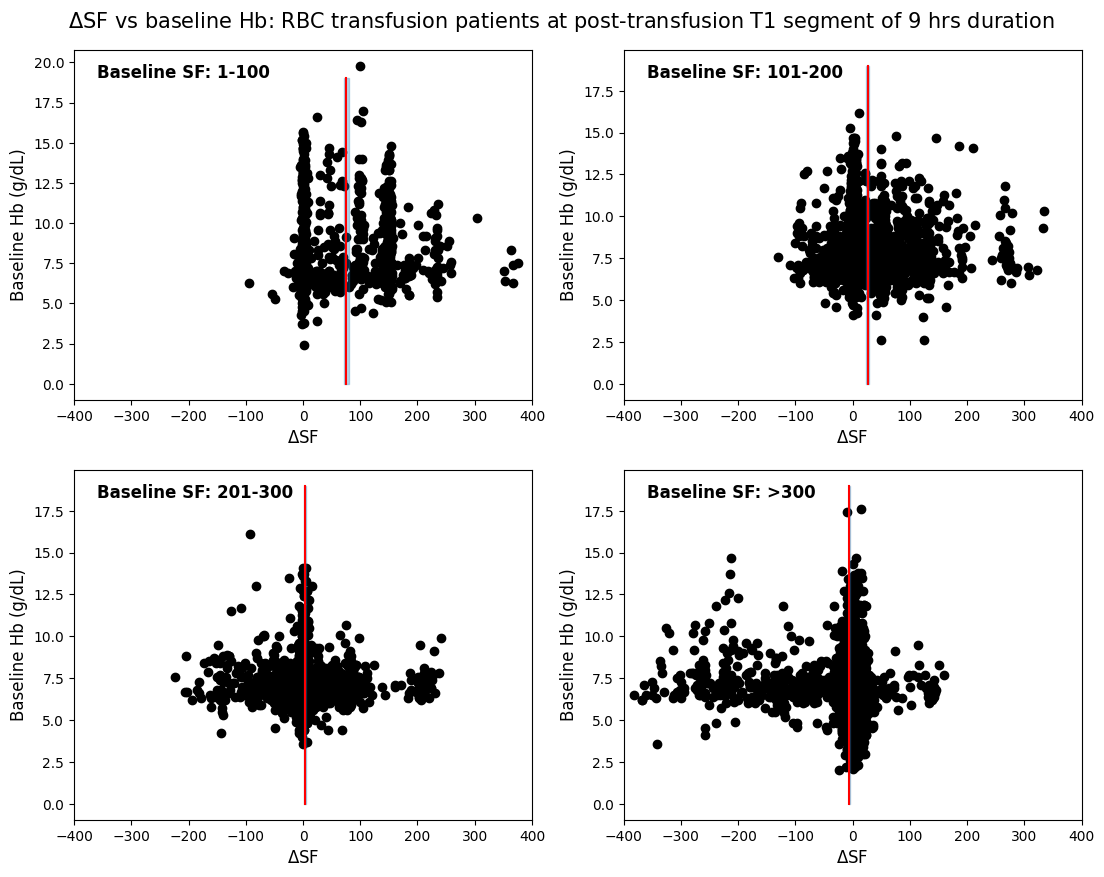

In [82]:
#in 2 x 2 subplots 
fig, axs = plt.subplots(2, 2, figsize =(13, 10))
line1 = np.arange(20)

axs[0,0].scatter(df_transf['del_SF_1a'], df_transf['Hb'],color='black')
#axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('$\Delta$SF', fontsize=12)
axs[0,0].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[0,0].set_xlim([-400, 400])
# axs[0,0].set_ylim([np.min(mHb1a)-0.5, np.max(mHb1a)+0.5])
axs[0,0].plot(np.mean(dSF1a)*np.ones(20), line1,color='red')
axs[0,0].fill_betweenx(line1, CI1a[0], CI1a[1], color='C0', alpha=0.3)


#----------------------------------------------------------------------------
axs[0,1].scatter(df_transf['del_SF_1b'], df_transf['Hb'],color='black')
axs[0,1].set_xlabel('$\Delta$SF', fontsize=12)
axs[0,1].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[0,1].set_xlim([-400, 400])
# axs[0,1].set_ylim([np.min(mHb1b)-0.5, np.max(mHb1b)+0.5])
axs[0,1].plot(np.mean(dSF1b)*np.ones(20), line1,color='red')
axs[0,1].fill_betweenx(line1, CI1b[0], CI1b[1], color='C0', alpha=0.3)

##--------------------------------------------------------------------
axs[1,0].scatter(df_transf['del_SF_1c'], df_transf['Hb'],color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('$\Delta$SF', fontsize=12)
axs[1,0].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[1,0].set_xlim([-400, 400])
# axs[1,0].set_ylim([np.min(mHb1c)-0.5, np.max(mHb1c)+0.5])
axs[1,0].plot(np.mean(dSF1c)*np.ones(20), line1,color='red')
axs[1,0].fill_betweenx(line1, CI1c[0], CI1c[1], color='C0', alpha=0.3)

##-----------------------------------------------------------------
axs[1,1].scatter(df_transf['del_SF_1d'], df_transf['Hb'],color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('$\Delta$SF', fontsize=12)
axs[1,1].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[1,1].set_xlim([-400, 400])
# axs[1,1].set_ylim([np.min(mHb1d)-0.5, np.max(mHb1d)+0.5])
axs[1,1].plot(np.mean(dSF1d)*np.ones(20), line1,color='red')
#axs[1,1].plot(CI1d[0]*np.ones(20), line1,'g:',CI1d[1]*np.ones(20), line1,'g:')
axs[1,1].fill_betweenx(line1, CI1d[0], CI1d[1], color='C0', alpha=0.3)


# Show texts
axs[0,0].text(0.051, 0.96, 'Baseline SF: 1-100', horizontalalignment='left', verticalalignment='top', transform=axs[0,0].transAxes, fontsize=12, fontdict=dict(weight='bold'))
axs[0,1].text(0.051, 0.96, 'Baseline SF: 101-200', horizontalalignment='left', verticalalignment='top', transform=axs[0,1].transAxes, fontsize=12, fontdict=dict(weight='bold'))
axs[1,0].text(0.051, 0.96, 'Baseline SF: 201-300', horizontalalignment='left', verticalalignment='top', transform=axs[1,0].transAxes, fontsize=12, fontdict=dict(weight='bold'))
axs[1,1].text(0.051, 0.96, 'Baseline SF: >300', horizontalalignment='left', verticalalignment='top', transform=axs[1,1].transAxes, fontsize=12, fontdict=dict(weight='bold'))


#ax2.text(0.9, 0.5, 'End text', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


plt.suptitle('$\Delta$SF vs baseline Hb: RBC transfusion patients at post-transfusion T1 segment of 9 hrs duration', fontsize = 15, y=0.92)#\u03C4=9hrs
#plt.show()

# plt.savefig('DATA_RESULTS/delSFvsHb_RedCellsT_withCI_2by2.png',format="png", bbox_inches="tight", dpi=300)

**$\Delta$ SF vs baseline SF**

In [83]:
np.max(MSFbaseline_gp1)+0.5

100.5

In [45]:
df_transf.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'pat_id', 'PAT_ID', 'csn',
       'encntr_id', 'dispense_dt_tm', 'estimated_transfusion_dt_tm',
       'product_cd_disp', 'bed_location_start', 'bed_location_end',
       'product_cat_cd_disp', 'orig_volume', 'year', 'hospital_service', 'Arb',
       'Tcount_7d', 'discharge_to', 'age', 'gender', 'race', 'ethnicity', 'Hb',
       'med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT',
       'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2', 'MSPO2_afterT3',
       'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3', 'MSF_afterT1',
       'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1', 'MPF_afterT2',
       'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3', 'del_Hb_1',
       'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3', 'del_PF_1',
       'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a', 'del_SF_2a',
       'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b', 'del_SF_1c',
       'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_

In [46]:
# MSFbaseline_gp1.isnull().sum()
df_transf['del_SF_2a'].isnull().sum()

21769

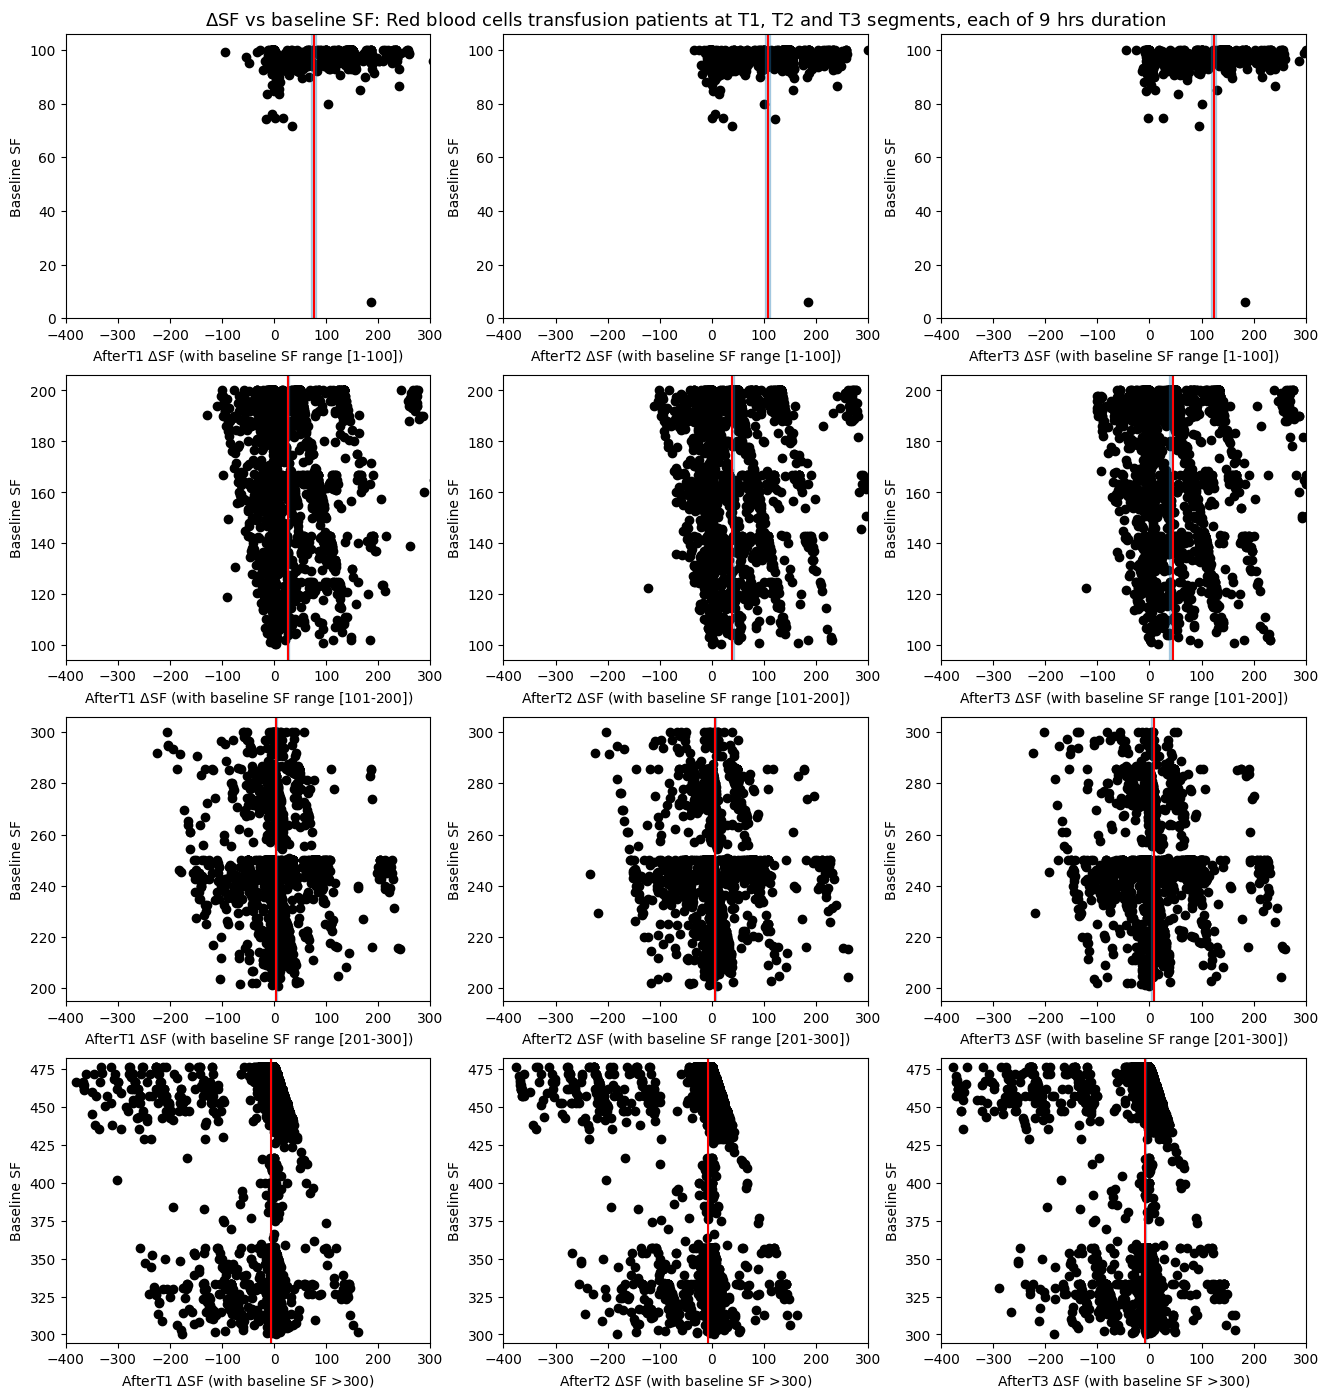

In [48]:
fig, axs = plt.subplots(4, 3, figsize =(16, 17))
line1 = np.arange(500)

axs[0,0].scatter(df_transf['del_SF_1a'], MSFbaseline_gp1,color='black')
#axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [1-100])')
axs[0,0].set_ylabel('Baseline SF')
axs[0,0].set_xlim([-400, 300])
axs[0,0].set_ylim([np.min(MSFbaseline_gp1)-6, np.max(MSFbaseline_gp1)+6])
axs[0,0].plot(np.mean(dSF1a)*np.ones(500), line1,color='red')
axs[0,0].fill_betweenx(line1, CI1a[0], CI1a[1], color='C0', alpha=0.3)


axs[0,1].scatter(df_transf['del_SF_2a'], MSFbaseline_gp1,color='black')
axs[0,1].set_title('$\Delta$SF vs baseline SF: Red blood cells transfusion patients at T1, T2 and T3 segments, each of 9 hrs duration', fontsize = 13)#\u03C4=9hrs
axs[0,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [1-100])')
axs[0,1].set_ylabel('Baseline SF')
axs[0,1].set_xlim([-400, 300])
axs[0,1].set_ylim([np.min(MSFbaseline_gp1)-6, np.max(MSFbaseline_gp1)+6])
axs[0,1].plot(np.mean(dSF2a)*np.ones(500), line1,color='red')
#axs[0,1].plot(CI2a[0]*np.ones(20), line1,'g:',CI2a[1]*np.ones(20), line1,'g:')
axs[0,1].fill_betweenx(line1, CI2a[0], CI2a[1], color='C0', alpha=0.3)


axs[0,2].scatter(df_transf['del_SF_3a'], MSFbaseline_gp1,color='black')
#axs[0,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [1-100])')
axs[0,2].set_ylabel('Baseline SF')
axs[0,2].set_xlim([-400, 300])
axs[0,2].set_ylim([np.min(MSFbaseline_gp1)-6, np.max(MSFbaseline_gp1)+6])
axs[0,2].plot(np.mean(dSF3a)*np.ones(500), line1,color='red')
#axs[0,2].plot(CI3a[0]*np.ones(20), line1,'g:',CI3a[1]*np.ones(20), line1,'g:')
axs[0,2].fill_betweenx(line1, CI3a[0], CI3a[1], color='C0', alpha=0.3)


#----------------------------------------------------------------------------
axs[1,0].scatter(df_transf['del_SF_1b'], MSFbaseline_gp2,color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [101-200])')
axs[1,0].set_ylabel('Baseline SF')
axs[1,0].set_xlim([-400, 300])
axs[1,0].set_ylim([np.min(MSFbaseline_gp2)-6, np.max(MSFbaseline_gp2)+6])
axs[1,0].plot(np.mean(dSF1b)*np.ones(500), line1,color='red')
axs[1,0].fill_betweenx(line1, CI1b[0], CI1b[1], color='C0', alpha=0.3)


axs[1,1].scatter(df_transf['del_SF_2b'], MSFbaseline_gp2,color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [101-200])')
axs[1,1].set_ylabel('Baseline SF')
axs[1,1].set_xlim([-400, 300])
axs[1,1].set_ylim([np.min(MSFbaseline_gp2)-6, np.max(MSFbaseline_gp2)+6])
axs[1,1].plot(np.mean(dSF2b)*np.ones(500), line1,color='red')
axs[1,1].fill_betweenx(line1, CI2b[0], CI2b[1], color='C0', alpha=0.3)


axs[1,2].scatter(df_transf['del_SF_3b'], MSFbaseline_gp2,color='black')
#axs[1,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [101-200])')
axs[1,2].set_ylabel('Baseline SF')
axs[1,2].set_xlim([-400, 300])
axs[1,2].set_ylim([np.min(MSFbaseline_gp2)-6, np.max(MSFbaseline_gp2)+6])
axs[1,2].plot(np.mean(dSF3b)*np.ones(500), line1,color='red')
axs[1,2].fill_betweenx(line1, CI3b[0], CI3b[1], color='C0', alpha=0.3)

##--------------------------------------------------------------------
axs[2,0].scatter(df_transf['del_SF_1c'], MSFbaseline_gp3,color='black')
#axs[2,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [201-300])')
axs[2,0].set_ylabel('Baseline SF')
axs[2,0].set_xlim([-400, 300])
axs[2,0].set_ylim([np.min(MSFbaseline_gp3)-6, np.max(MSFbaseline_gp3)+6])
axs[2,0].plot(np.mean(dSF1c)*np.ones(500), line1,color='red')
axs[2,0].fill_betweenx(line1, CI1c[0], CI1c[1], color='C0', alpha=0.3)


axs[2,1].scatter(df_transf['del_SF_2c'], MSFbaseline_gp3,color='black')
#axs[2,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [201-300])')
axs[2,1].set_ylabel('Baseline SF')
axs[2,1].set_xlim([-400, 300])
axs[2,1].set_ylim([np.min(MSFbaseline_gp3)-6, np.max(MSFbaseline_gp3)+6])
axs[2,1].plot(np.mean(dSF2c)*np.ones(500), line1,color='red')
axs[2,1].fill_betweenx(line1, CI2c[0], CI2c[1], color='C0', alpha=0.3)

axs[2,2].scatter(df_transf['del_SF_3c'], MSFbaseline_gp3,color='black')
#axs[2,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [201-300])')
axs[2,2].set_ylabel('Baseline SF')
axs[2,2].set_xlim([-400, 300])
axs[2,2].set_ylim([np.min(MSFbaseline_gp3)-6, np.max(MSFbaseline_gp3)+6])
axs[2,2].plot(np.mean(dSF3c)*np.ones(500), line1,color='red')
axs[2,2].fill_betweenx(line1, CI3c[0], CI3c[1], color='C0', alpha=0.3)

##-----------------------------------------------------------------
axs[3,0].scatter(df_transf['del_SF_1d'], MSFbaseline_gp4,color='black')
#axs[3,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF >300)')
axs[3,0].set_ylabel('Baseline SF')
axs[3,0].set_xlim([-400, 300])
axs[3,0].set_ylim([np.min(MSFbaseline_gp4)-6, np.max(MSFbaseline_gp4)+6])
axs[3,0].plot(np.mean(dSF1d)*np.ones(500), line1,color='red')
#axs[3,0].plot(CI1d[0]*np.ones(20), line1,'g:',CI1d[1]*np.ones(20), line1,'g:')
axs[3,0].fill_betweenx(line1, CI1d[0], CI1d[1], color='C0', alpha=0.3)

axs[3,1].scatter(df_transf['del_SF_2d'], MSFbaseline_gp4,color='black')
#axs[3,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF >300)')
axs[3,1].set_ylabel('Baseline SF')
axs[3,1].set_xlim([-400, 300])
axs[3,1].set_ylim([np.min(MSFbaseline_gp4)-6, np.max(MSFbaseline_gp4)+6])
axs[3,1].plot(np.mean(dSF2d)*np.ones(500), line1,color='red')
#axs[3,1].plot(CI2d[0]*np.ones(20), line1,'g:',CI2d[1]*np.ones(20), line1,'g:')
axs[3,1].fill_betweenx(line1, CI2d[0], CI2d[1], color='C0', alpha=0.3)

axs[3,2].scatter(df_transf['del_SF_3d'], MSFbaseline_gp4,color='black')
#axs[3,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF >300)')
axs[3,2].set_ylabel('Baseline SF')
axs[3,2].set_xlim([-400, 300])
axs[3,2].set_ylim([np.min(MSFbaseline_gp4)-6, np.max(MSFbaseline_gp4)+6])
axs[3,2].plot(np.mean(dSF3d)*np.ones(500), line1,color='red')
#axs[3,2].plot(CI3d[0]*np.ones(20), line1,'g:',CI3d[1]*np.ones(20), line1,'g:')
axs[3,2].fill_betweenx(line1, CI3d[0], CI3d[1], color='C0', alpha=0.3)

# plt.savefig('DATA_RESULTS/delSFvsBSF_RedCellsT_withCI.png',format="png", bbox_inches="tight", dpi=300)


In [49]:
np.shape(dSF1b), np.shape(MSFbaseline_gp2)

((2605,), (22874,))

## Relation establishment: Baseline SF and RBC.T. efficacy (Delta SF)

In [84]:
from scipy.optimize import curve_fit

In [85]:
def func(x, a, b, c, d):
    return (a*(x)**3) + (b*(x)**2) + (c*(x)) + d

In [86]:
# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

In [87]:
# xdata = [100, 200, 300, 400]
#xdata = np.append(np.append(np.append(100*np.ones(len(dSF1a)), 200*np.ones(len(dSF1b))), 300*np.ones(len(dSF1c))), 400*np.ones(len(dSF1d))) #Quantized baseline SF 


# BSFa = MSFbaseline_gp1.values #MSFbaseline_gp1[~np.isnan(MSFbaseline_gp1)]
# BSFb = MSFbaseline_gp2.values  #MSFbaseline_gp2[~np.isnan(MSFbaseline_gp2)]
# BSFc = MSFbaseline_gp3.values  #MSFbaseline_gp3[~np.isnan(MSFbaseline_gp3)]
# BSFd = MSFbaseline_gp4.values  #MSFbaseline_gp4[~np.isnan(MSFbaseline_gp4)]
# xdata = np.append(np.append(np.append(BSFa, BSFb), BSFc), BSFd) #consider original/actual baseline SF

In [88]:
xdata = pd.concat([MSFbaseline_gp1,MSFbaseline_gp2,MSFbaseline_gp3,MSFbaseline_gp4])

In [89]:
ydata = pd.concat([df_transf['del_SF_1a'],df_transf['del_SF_1b'],df_transf['del_SF_1c'],df_transf['del_SF_1d']])

In [90]:
# # ydata = [np.mean(dSF1a), np.mean(dSF1b), np.mean(dSF1c), np.mean(dSF1d)]
# # ydata = [np.array(dSF1a), np.array(dSF1b), np.array(dSF1c), np.array(dSF1d)]
# # ydata = np.append([dSF1a1, dSF1b1, dSF1c1], dSF1d1)
# # dSF1a1 = np.transpose(list(dSF1a))
# # dSF1b1 = np.transpose(list(dSF1b))
# # dSF1c1 = np.transpose(list(dSF1c))
# # dSF1d1 = np.transpose(list(dSF1d))

# dSF1a1 = df_transf['del_SF_1a'].values
# dSF1b1 = df_transf['del_SF_1b'].values
# dSF1c1 = df_transf['del_SF_1c'].values
# dSF1d1 = df_transf['del_SF_1d'].values
# ydata = np.append(np.append(np.append(dSF1a1, dSF1b1), dSF1c1), dSF1d1)


In [91]:
xy=pd.concat([xdata, ydata], axis=1)
xy

,0,1
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None
...,...,...
22862,466.666667,0.0
22863,323.75,-171.25
22864,None,NaN
22865,476.190476,0.0


In [92]:
xy2 = xy[~xy.isnull().any(axis=1)]
xy2.reset_index(drop=True, inplace=True)
xy2

,0,1
0,94.666667,-0.166667
1,96.0,236.222222
2,92.333333,155.166667
3,99.0,0.5
4,99.0,107.666667
...,...,...
17279,447.619048,23.809524
17280,466.666667,0.0
17281,323.75,-171.25
17282,476.190476,0.0


In [93]:
xy2 = xy2[xy2[0]>60]

In [94]:
xy2.sort_values(by=[0], inplace=True)

/tmp/ipykernel_5709/3030813068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xy2.sort_values(by=[0], inplace=True)


In [95]:
xy2[0].min(), xy2[0].max()

(71.5, 476.1904761904762)

In [96]:
xdata_new = xy2.iloc[:,0].values
ydata_new = xy2.iloc[:,1].values

In [97]:
popt, pcov = curve_fit(func, xdata_new, ydata_new)

In [98]:
popt

array([-2.35488266e-06,  3.03894846e-03, -1.27690981e+00,  1.68109138e+02])

In [99]:
pcov

array([[ 1.14429172e-13, -9.76890796e-11,  2.44267144e-08,
        -1.73667632e-06],
       [-9.76890796e-11,  8.41655874e-08, -2.13337614e-05,
         1.54350682e-03],
       [ 2.44267144e-08, -2.13337614e-05,  5.52148557e-03,
        -4.11054926e-01],
       [-1.73667632e-06,  1.54350682e-03, -4.11054926e-01,
         3.20635612e+01]])

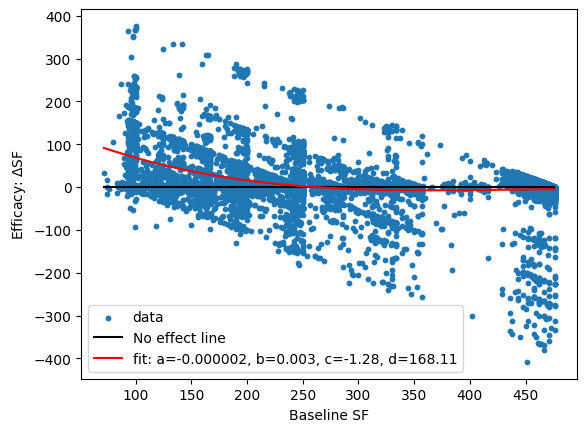

In [100]:
plt.scatter(xdata_new, ydata_new, label='data', s=10)
ll = np.arange(xdata_new.min(), xdata_new.max())
plt.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')
plt.plot(xdata_new, func(xdata_new, *popt), 'r-',label='fit: a=%5.6f, b=%5.3f, c=%5.2f, d=%5.2f' % tuple(popt))
plt.xlabel('Baseline SF')
plt.ylabel('Efficacy: $\Delta$SF')


plt.legend()
# plt.xlim([0,500])
# plt.ylim([-500,500])
plt.show()

Text(0, 0.5, 'Efficacy: $\\Delta$SF')

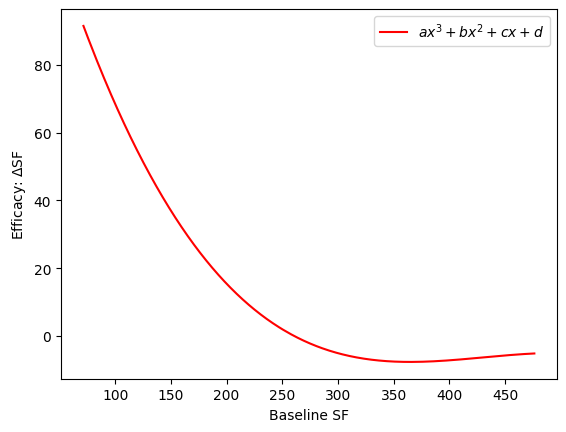

In [101]:
plt.plot(xdata_new, func(xdata_new, *popt), 'r-',label='$ax^3 + bx^2 + cx + d$' )
plt.legend()
plt.xlabel('Baseline SF')
plt.ylabel('Efficacy: $\Delta$SF')

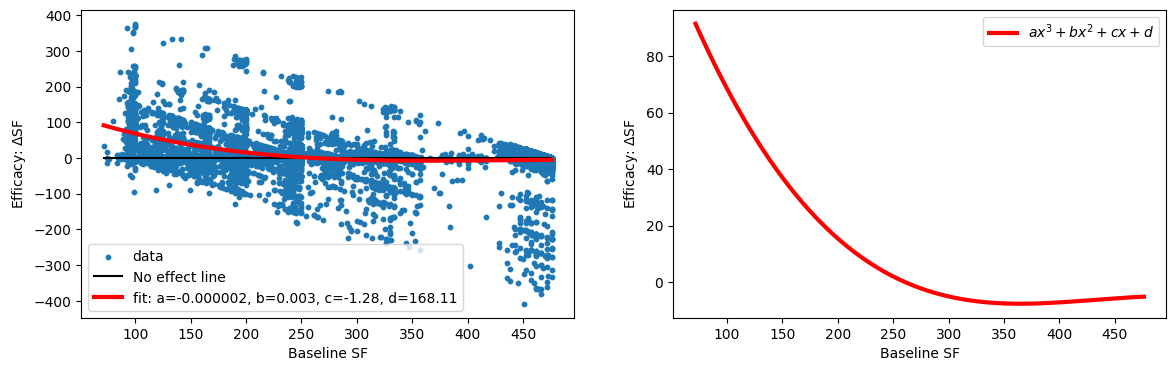

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(xdata_new, ydata_new, label='data', s=10)
ll = np.arange(xdata_new.min(), xdata_new.max())
ax1.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')
ax1.plot(xdata_new, func(xdata_new, *popt), 'r-',label='fit: a=%5.6f, b=%5.3f, c=%5.2f, d=%5.2f' % tuple(popt), lw=3)
ax1.set_xlabel('Baseline SF')
ax1.set_ylabel('Efficacy: $\Delta$SF')
ax1.legend()

ax2.plot(xdata_new, func(xdata_new, *popt), 'r-',label='$ax^3 + bx^2 + cx + d$' , lw=3)
ax2.legend()
ax2.set_xlabel('Baseline SF')
ax2.set_ylabel('Efficacy: $\Delta$SF')

# plt.xlim([0,500])
# plt.ylim([-500,500])
plt.show()

In [103]:
import sklearn
print('R2 square : ',sklearn.metrics.r2_score(ydata_new, func(xdata_new, *popt)))

R2 square :  0.1900014850908187


### Next Method

In [74]:
# pip install statsmodels

R2 square :  0.16712302117232003


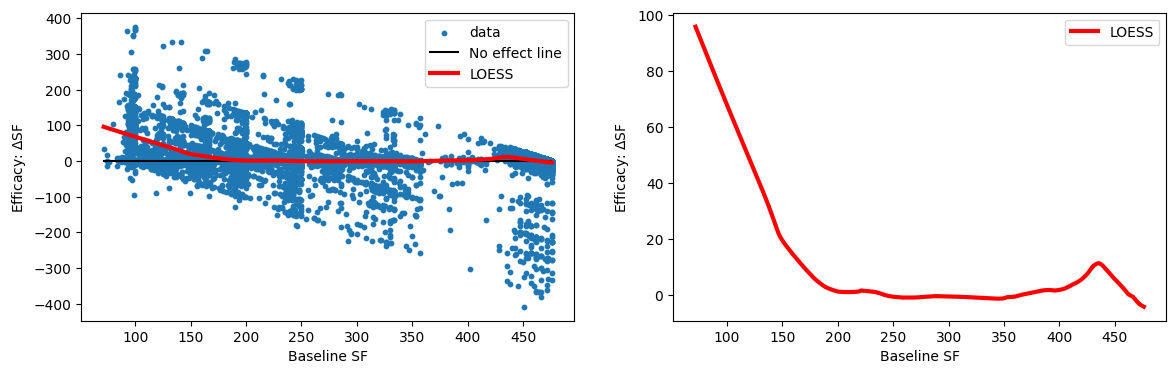

In [109]:
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(xdata_new, ydata_new, label='data', s=10)
ll = np.arange(xdata_new.min(), xdata_new.max())
ax1.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')


filtered = lowess(ydata_new, xdata_new, frac=0.21) #frac=0.15
ax1.plot(filtered[:, 0], filtered[:, 1], 'r-',label='LOESS', lw=3)
ax1.set_xlabel('Baseline SF')
ax1.set_ylabel('Efficacy: $\Delta$SF')
ax1.legend()



ax2.plot(filtered[:, 0], filtered[:, 1], 'r-',label='LOESS', lw=3)
ax2.legend()
ax2.set_xlabel('Baseline SF')
ax2.set_ylabel('Efficacy: $\Delta$SF')

print('R2 square : ', sklearn.metrics.r2_score(ydata_new, filtered[:, 1]))
# # plt.xlim([0,500])
# # plt.ylim([-500,500])
plt.show()

In [93]:
print('R2 square : ',sklearn.metrics.r2_score(ydata_new, filtered[:, 1]))

R2 square :  0.16366930204300867


In [106]:
np.arange(0.01,0.3, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])

In [69]:
z = np.polyfit(list(xdata_new), list(ydata_new), 3)
p = np.poly1d(z)
z

array([-2.35488269e-06,  3.03894848e-03, -1.27690981e+00,  1.68109138e+02])

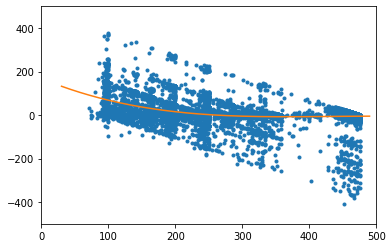

In [70]:
xp = np.linspace(30, 490, 200)
plt.plot(xdata_new, ydata_new, '.', xp, p(xp), '-')
plt.xlim([0,500])
plt.ylim([-500,500])
plt.show()

In [71]:
#define function to calculate adjusted r-squared
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return results

In [72]:
adjR(list(xdata_new), list(ydata_new), 1)

{'r_squared': 0.1230742409825526}

**Modification/Postprocessing of ydata (i.e. $\Delta$SF)** 

For same baseline SFs, find mean of $\Delta$SFs. xdata: baseline SF, ydata: $\Delta$SF

In [73]:
xdata

0              None
1              None
2              None
3              None
4              None
            ...    
22869    466.666667
22870        323.75
22871          None
22872    476.190476
22873         350.0
Length: 91496, dtype: object

In [74]:
x=[1, 5, 3, 9, 5, 3, 2, 5]
y=[100, 120, 140, 100, 400, 200, 250, 300]

In [75]:
data = {'x1':xdata_new, 'y1':ydata_new}

In [76]:
df1=pd.DataFrame(data)
df1

,x1,y1
0,71.5,33.763158
1,74.25,-15.25
2,74.5,0.9
3,74.666667,17.333333
4,76.0,-4.0
...,...,...
17278,476.190476,-9.52381
17279,476.190476,-4.761905
17280,476.190476,-4.761905
17281,476.190476,0.0


In [77]:
df2=df1.sort_values(by=['x1']).reset_index(drop=True)

In [78]:
df2

,x1,y1
0,71.5,33.763158
1,74.25,-15.25
2,74.5,0.9
3,74.666667,17.333333
4,76.0,-4.0
...,...,...
17278,476.190476,0.0
17279,476.190476,0.0
17280,476.190476,-4.761905
17281,476.190476,0.0


In [79]:
xdata_n = np.unique(df2['x1'])
xdata_n

array([71.5, 74.25, 74.5, ..., 475.7936507936508, 475.8928571428572,
       476.1904761904762], dtype=object)

In [80]:
ydata_n = []
for i in xdata_n:
    ids=np.where(df2['x1']==i)
    # print(ids[0])
    mn = np.mean(df2['y1'].iloc[ids[0]])
    ydata_n = np.append(ydata_n, mn)

## TE=a(1/BSF)+b

In [81]:
z = np.polyfit(list(1/xdata_n), ydata_n, 3)
p = np.poly1d(z)
z

array([-1.77693141e+08,  3.27189814e+06, -9.41668647e+03, -5.79826443e+00])

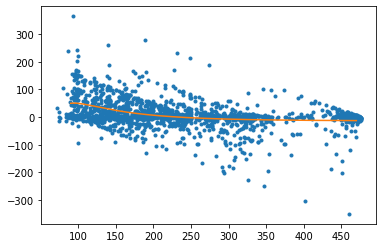

In [82]:
xp = np.linspace(90, 470, 5000)
plt.plot(xdata_n, ydata_n, '.', xp, p(1/xp), '-')
plt.show()

In [83]:
adjR(list(xdata_n), ydata_n, 1)

{'r_squared': 0.11393105420219662}

## Delta PF vs baseline Hb

In [84]:

# df_transf['del_PF_1']=df_transf['MPF_afterT1'] - df_transf['MPF_beforeT']
# df_transf['del_PF_2']=df_transf['MPF_afterT2'] - df_transf['MPF_beforeT']
# df_transf['del_PF_3']=df_transf['MPF_afterT3'] - df_transf['MPF_beforeT']

Text(0, 0.5, 'Baseline Hb (g/dL)')

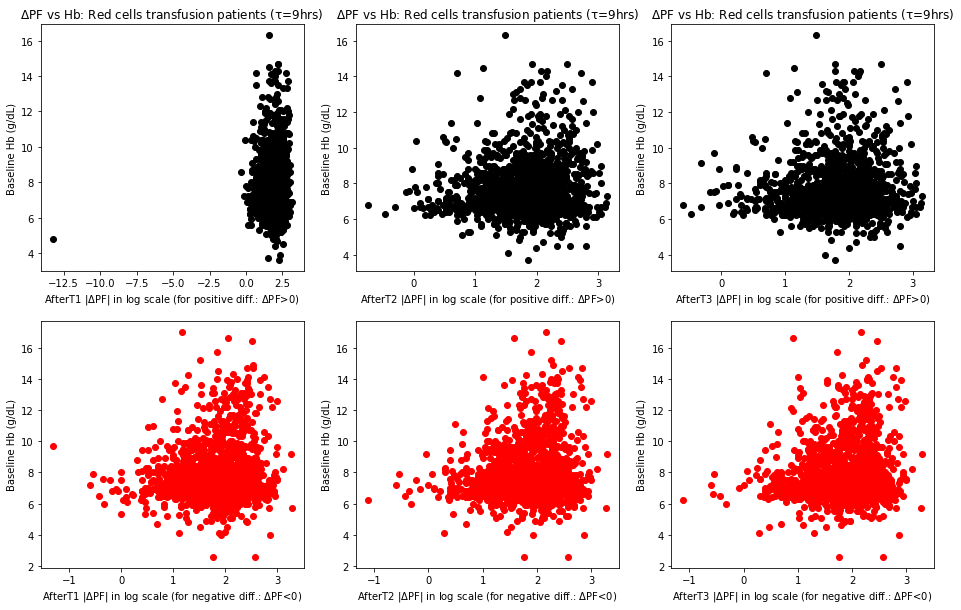

In [85]:
fig, axs = plt.subplots(2, 3, figsize =(16, 10))

delPF1=df_transf['del_PF_1'][df_transf['del_PF_1']>0]
Hb1 = df_transf['Hb'][df_transf['del_PF_1']>0]
axs[0,0].scatter(np.log10(delPF1), Hb1, color='black')
axs[0,0].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 |$\Delta$PF| in log scale (for positive diff.: $\Delta$PF>0)')
axs[0,0].set_ylabel('Baseline Hb (g/dL)')
#axs[0].set_xscale('symlog')#loglog(basex=10)

delPF2=df_transf['del_PF_2'][df_transf['del_PF_2']>0]
Hb2 = df_transf['Hb'][df_transf['del_PF_2']>0]
axs[0,1].scatter(np.log10(delPF2), Hb2,color='black')
axs[0,1].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,1].set_xlabel('AfterT2 |$\Delta$PF| in log scale (for positive diff.: $\Delta$PF>0)')
axs[0,1].set_ylabel('Baseline Hb (g/dL)')
#axs[1].set_xscale('symlog')#loglog(basex=10)

delPF3=df_transf['del_PF_3'][df_transf['del_PF_3']>0]
Hb3 = df_transf['Hb'][df_transf['del_PF_3']>0]
axs[0,2].scatter(np.log10(delPF3), Hb3,color='black')
axs[0,2].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 |$\Delta$PF| in log scale (for positive diff.: $\Delta$PF>0)')
axs[0,2].set_ylabel('Baseline Hb (g/dL)')
#axs[2].set_xscale('symlog')#loglog(basex=10)

#-------------------
delPF1n=np.abs(df_transf['del_PF_1'][df_transf['del_PF_1']<0])
Hb1n = df_transf['Hb'][df_transf['del_PF_1']<0]
axs[1,0].scatter(np.log10(delPF1n), Hb1n, color='red')
#axs[1,0].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 |$\Delta$PF| in log scale (for negative diff.: $\Delta$PF<0)')
axs[1,0].set_ylabel('Baseline Hb (g/dL)')
#axs[0].set_xscale('symlog')#loglog(basex=10)

delPF2n=np.abs(df_transf['del_PF_2'][df_transf['del_PF_2']<0])
Hb2n = df_transf['Hb'][df_transf['del_PF_2']<0]
axs[1,1].scatter(np.log10(delPF2n), Hb2n,color='red')
#axs[1,1].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 |$\Delta$PF| in log scale (for negative diff.: $\Delta$PF<0)')
axs[1,1].set_ylabel('Baseline Hb (g/dL)')
#axs[1].set_xscale('symlog')#loglog(basex=10)

delPF3n=np.abs(df_transf['del_PF_3'][df_transf['del_PF_3']<0])
Hb3n = df_transf['Hb'][df_transf['del_PF_3']<0]
axs[1,2].scatter(np.log10(delPF3n), Hb3n,color='red')
#axs[1,2].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 |$\Delta$PF| in log scale (for negative diff.: $\Delta$PF<0)')
axs[1,2].set_ylabel('Baseline Hb (g/dL)')
#axs[2].set_xscale('symlog')#loglog(basex=10)

# plt.savefig('DATA_RESULTS/delPFvsHb_RedCellsT_6_23_22_delPF_log.png')

## Find Demographics

In [86]:
df_transf.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'pat_id', 'PAT_ID', 'csn',
       'encntr_id', 'dispense_dt_tm', 'estimated_transfusion_dt_tm',
       'product_cd_disp', 'bed_location_start', 'bed_location_end',
       'product_cat_cd_disp', 'orig_volume', 'year', 'hospital_service', 'Arb',
       'Tcount_7d', 'discharge_to', 'age', 'gender', 'race', 'ethnicity', 'Hb',
       'med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT',
       'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2', 'MSPO2_afterT3',
       'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3', 'MSF_afterT1',
       'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1', 'MPF_afterT2',
       'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3', 'del_Hb_1',
       'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3', 'del_PF_1',
       'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a', 'del_SF_2a',
       'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b', 'del_SF_1c',
       'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_

In [87]:
Total_T_instances = len(df_transf)
Total_T_instances

22874

In [88]:
Total_pat_csn = len(np.unique(df_transf['csn']))
Total_pat_csn

14765

In [89]:
csns = df_transf['csn']

In [90]:
df_transf.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'pat_id', 'PAT_ID', 'csn',
       'encntr_id', 'dispense_dt_tm', 'estimated_transfusion_dt_tm',
       'product_cd_disp', 'bed_location_start', 'bed_location_end',
       'product_cat_cd_disp', 'orig_volume', 'year', 'hospital_service', 'Arb',
       'Tcount_7d', 'discharge_to', 'age', 'gender', 'race', 'ethnicity', 'Hb',
       'med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT',
       'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2', 'MSPO2_afterT3',
       'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3', 'MSF_afterT1',
       'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1', 'MPF_afterT2',
       'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3', 'del_Hb_1',
       'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3', 'del_PF_1',
       'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a', 'del_SF_2a',
       'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b', 'del_SF_1c',
       'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_

In [91]:
# df_transf['sf_range'] = 

In [92]:
### TABLEONE


## Table One of Demographic and Important Features

In [93]:
# cols = .....


# from tableone import TableOne
# groupby = ['kmean_cluster']
# cols = cols
# categorical=['gender','race','ethnicity']

# ##### limit the binary variable to a single row
# # limit = {"hispanic": 1}
# labels={'kmean_cluster': 'RBC Trnasfusion Phenotypes'}
# data = medianAllSuperTable3new
# phenotypes_unimputed = TableOne(data, missing=False, columns=cols, categorical=categorical, groupby=groupby,rename=labels,label_suffix=True, pval=True, htest_name=True) #, nonnormal=nonnormal) #, limit=limit) 
# #, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, rename=labels, pval=False)
# phenotypes_unimputed

# # phenotypes_unimputed.to_latex('tableoneEmory_unimputed_v1g.tex')
# # phenotypes_unimputed.to_csv('tableoneEmory_unimputed_v1g.csv')

In [95]:
df_transf.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'pat_id', 'PAT_ID', 'csn',
       'encntr_id', 'dispense_dt_tm', 'estimated_transfusion_dt_tm',
       'product_cd_disp', 'bed_location_start', 'bed_location_end',
       'product_cat_cd_disp', 'orig_volume', 'year', 'hospital_service', 'Arb',
       'Tcount_7d', 'discharge_to', 'age', 'gender', 'race', 'ethnicity', 'Hb',
       'med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT',
       'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2', 'MSPO2_afterT3',
       'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3', 'MSF_afterT1',
       'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1', 'MPF_afterT2',
       'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3', 'del_Hb_1',
       'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3', 'del_PF_1',
       'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a', 'del_SF_2a',
       'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b', 'del_SF_1c',
       'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_

In [ ]:
df_transf[['csn','year']]

In [104]:
from multiprocessing import Pool
import time
import warnings
warnings.filterwarnings('ignore')
start=time.time()
def f1(i):
    AllSuperTable = pd.DataFrame([])
    try:
        transT = pd.to_datetime(df_transf.iloc[i]['estimated_transfusion_dt_tm'])
        year = df_transf.iloc[i]['year']   #pd.to_datetime(IntersectionBeforeT_RBC.iloc[i]['FileStart']).year #dt.year
        csn = df_transf.iloc[i]['csn']
        
        ## Assessing super table
        pkl_path = '/labs/kamaleswaranlab/MODS/Encounter_Pickles/em/'+str(year)+'/'+str(csn)+'.pickle'
        with open(pkl_path, 'rb') as pf:
            patient_enc_dict = pickle.load(pf)
        super_table = patient_enc_dict['super_table']
        super_table['Time']=super_table.index
        
        super_table0 = super_table.pop('Time')
        super_table.insert(0, 'Time', super_table0) #First column is "Time" now [moved from last to first column]
        
                       
        #*---------- Preprocessings -------------*#
        super_table.index=np.arange(len(super_table))
        super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
        super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)
    
                
        
        
        #Get these measures for beforeT
        a = np.array((transT-super_table['Time']).dt.days)
        
        
        #Find the sign change to identify transfusion time
        id1=np.where(a>=0)
        beforeTid = id1[0][-1] #Closest and before the transfusion starts
        
        #Inter-sample interval is 1 hr in super_table
        if beforeTid >= 23: 
            super_table_BeforeT = super_table.iloc[beforeTid-23: beforeTid+1]
            super_table_BeforeT['SOFA_admission_hourly_total'] = patient_enc_dict['sofa_scores']['hourly_total'][0]
            super_table_BeforeT['SOFA_max_hourly_total'] = patient_enc_dict['sofa_scores']['hourly_total'][beforeTid-23: beforeTid+1].max()
            #One hot encoding for some categorical features
            indx = list(super_table_BeforeT.columns).index('temperature')
            super_table_BeforeT_Dummies = pd.get_dummies(super_table_BeforeT.iloc[:,indx:],drop_first=True)
            super_table_BeforeT_New = pd.concat([super_table_BeforeT.iloc[:,:indx], super_table_BeforeT_Dummies], axis=1)
            
        elif beforeTid > 2 and beforeTid < 23:    
            super_table_BeforeT = super_table.iloc[: beforeTid+1]
            super_table_BeforeT['SOFA_admission_hourly_total'] = patient_enc_dict['sofa_scores']['hourly_total'][0]
            super_table_BeforeT['SOFA_max_hourly_total'] = patient_enc_dict['sofa_scores']['hourly_total'][: beforeTid+1].max()
            #One hot encoding for some categorical features
            indx = list(super_table_BeforeT.columns).index('temperature')
            super_table_BeforeT_Dummies = pd.get_dummies(super_table_BeforeT.iloc[:,indx:],drop_first=True)
            super_table_BeforeT_New = pd.concat([super_table_BeforeT.iloc[:,:indx], super_table_BeforeT_Dummies], axis=1)
        else:
            super_table_BeforeT_New = []
            #print('Removed')
        
        
        
        #Discarding patient with no data present beforeT 3hrs window
        #Concatenation of features with broadcasted patient info
        Ls = len(super_table_BeforeT_New)
        if Ls>0:
            
            ###median calculation
            # initials = pd.DataFrame(super_table_BeforeT_New.loc[:'ethnicity']).T
            a1 = pd.DataFrame(super_table_BeforeT_New.loc[:,'temperature':].median(axis = 0)).T
            # a1 = pd.concat([initials, a], axis=1)
            
            z = pd.DataFrame(df_transf.iloc[i]).T
            z['discharge_to'] = patient_enc_dict['static_features']['discharge_to']
            z['age'] = patient_enc_dict['static_features']['age']
            z['gender'] = patient_enc_dict['static_features']['gender']
            z['race'] = patient_enc_dict['static_features']['race']
            z['ethnicity'] = patient_enc_dict['static_features']['ethnicity']
            
            z.reset_index(drop=True, inplace=True)
            a1.reset_index(drop=True, inplace=True)
            super_table_BeforeT_New1 = pd.concat([z, a1], axis=1)
            AllSuperTable = AllSuperTable.append(super_table_BeforeT_New1)
    except FileNotFoundError:
        print('FileNotFoundError:',i)
        pass
    return AllSuperTable

p = Pool(12)
results = p.map(f1, range(0,df_transf.shape[0]))   
p.close()
p.join()        
AllSuperTable_1 = pd.concat(results, ignore_index=True)
end = time.time()
print('Completed in: %s sec'%(end - start))

Completed in: 482.6216723918915 sec


In [ ]:
AllSuperTable_1

In [106]:
AllSuperTable_2 = AllSuperTable_1[~AllSuperTable_1['med_SF_beforeT'].isnull()]
AllSuperTable_2.reset_index(drop=True, inplace=True)

bsf = AllSuperTable_2['med_SF_beforeT']
cond1 =  bsf>0 
cond2 = bsf<=100
cond12 = cond1 & cond2
C1 = pd.Series(cond12, dtype=int)*1

cond1 =  bsf>100 
cond2 = bsf<=200
cond12 = cond1 & cond2
C2 = pd.Series(cond12, dtype=int)*2

cond1 =  bsf>200 
cond2 = bsf<=300
cond12 = cond1 & cond2
C3 = pd.Series(cond12, dtype=int)*3

cond1 =  bsf>300 
cond12 = cond1
C4 = pd.Series(cond12, dtype=int)*4

AllSuperTable_2['BSF_group'] = C1 + C2 + C3 + C4

In [ ]:
AllSuperTable_2

In [107]:
AllSuperTable_2.race.unique(), AllSuperTable_2.ethnicity.unique(), AllSuperTable_2['BSF_group'].unique()

(array(['African American  or Black', 'Caucasian or White',
        'American Indian or Alaskan Native',
        'Unknown, Unavailable or Unreported', 'Asian', 'Multiple',
        'Native Hawaiian or Other Pacific Islander'], dtype=object),
 array(['Non-Hispanic or Latino', 'Unreported, Unknown, Unavailable',
        'Not Recorded', 'Non-Hispanic~Unknown', 'Hispanic or Latino',
        'Unknown~Non-Hispanic', 'Unknown~Hispanic', 'CD:1641210453',
        'CD:1565395161', 'CD:1902530759'], dtype=object),
 array([4, 3, 2, 1]))

In [108]:
AllSuperTable_2.reset_index(drop=True, inplace=True)
race_others_i = AllSuperTable_2[~AllSuperTable_2.race.isin(['African American  or Black', 'Caucasian or White'])].loc[:,'race'].index
AllSuperTable_2['race'].iloc[race_others_i] = 'Others'
AllSuperTable_2.race.unique()

array(['African American  or Black', 'Caucasian or White', 'Others'],
      dtype=object)

In [109]:
AllSuperTable_2.reset_index(drop=True, inplace=True)
eth_others_i = AllSuperTable_2[~AllSuperTable_2.ethnicity.isin(['Non-Hispanic or Latino','Hispanic or Latino'])].loc[:,'ethnicity'].index
AllSuperTable_2['ethnicity'].iloc[eth_others_i] = 'Others'
AllSuperTable_2.ethnicity.unique()

array(['Non-Hispanic or Latino', 'Others', 'Hispanic or Latino'],
      dtype=object)

In [ ]:
AllSuperTable_2

In [114]:
print('Unique CSNs:',len(AllSuperTable_2.csn.unique()), len(AllSuperTable_2[AllSuperTable_2.BSF_group==1].csn.unique()),
      len(AllSuperTable_2[AllSuperTable_2.BSF_group==2].csn.unique()),len(AllSuperTable_2[AllSuperTable_2.BSF_group==3].csn.unique()),
     len(AllSuperTable_2[AllSuperTable_2.BSF_group==4].csn.unique())) 

print('Unique Patients:',len(AllSuperTable_2.pat_id.unique()), len(AllSuperTable_2[AllSuperTable_2.BSF_group==1].pat_id.unique()),
      len(AllSuperTable_2[AllSuperTable_2.BSF_group==2].pat_id.unique()),len(AllSuperTable_2[AllSuperTable_2.BSF_group==3].pat_id.unique()),
      len(AllSuperTable_2[AllSuperTable_2.BSF_group==4].pat_id.unique()))

Unique CSNs: 13274 1258 2373 2763 8098
Unique Patients: 11828 1250 2312 2672 7254


In [115]:
cols = ['age', 'gender','race','ethnicity', 'daily_weight_kg', 'height_cm',#'Tcount_7d',
        'hematocrit', 'hemoglobin',
        #'best_map','pulse',
        'blood_urea_nitrogen_(bun)','creatinine','platelets',# 'white_blood_cell_count',
        'bilirubin_total', #'fibrinogen', 
        'inr',#'partial_prothrombin_time_(ptt)',#'b-type_natriuretic_peptide_(bnp)',
        'fio2','pf_sp','pf_pa',
        'gcs_total_score','SOFA_max_hourly_total']


from tableone import TableOne
groupby = ['BSF_group']
cols = cols
categorical=['gender','race','ethnicity']

##### limit the binary variable to a single row
# limit = {"hispanic": 1}
labels={'BSF_group': 'Baseline SF groups'}
data = AllSuperTable_2
data_unimputed = TableOne(data, missing=False, columns=cols, categorical=categorical, groupby=groupby,rename=labels,label_suffix=True, pval=True, htest_name=True) #, nonnormal=nonnormal) #, limit=limit) 
#, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, rename=labels, pval=False)
data_unimputed



# data_unimputed.to_latex('tableoneEmory_unimputed_ver3.tex')
# data_unimputed.to_csv('tableoneEmory_unimputed_ver3.csv')

/home/tchoud7/.local/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/tchoud7/.local/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/tchoud7/.local/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and th

Grouped by Baseline SF groups                                                                                   
                                                                                      Overall              1              2              3              4 P-Value           Test
n                                                                                       18716           1303           2851           3552          11010                       
age, mean (SD)                                                                    61.4 (16.0)    62.4 (15.5)    60.5 (15.2)    61.2 (15.0)    61.6 (16.5)   0.001  One-way ANOVA
gender, n (%)                        Female                                       9708 (51.9)     633 (48.6)    1484 (52.1)    1787 (50.3)    5804 (52.7)   0.006    Chi-squared
                                     Male                                         9008 (48.1)     670 (51.4)    1367 (47.9)    1765 (49.7)    5206 (47.3)                       
race, n (%)                          African American  or Black                   8428 (45.0)     518 (39.8)    1060 (37.2)    1554 (43.8)    5296 (48.1)  <0.001    Chi-squared
                                     Caucasian or White                           8724 (46.6)     652 (50.0)    1477 (51.8)    1677 (47.2)    4918 (44.7)                       
                                     Others                                        1564 (8.4)     133 (10.2)     314 (11.0)      321 (9.0)      796 (7.2)                       
ethnicity, n (%)                     Hispanic or Latino                             574 (3.1)       36 (2.8)      107 (3.8)      113 (3.2)      318 (2.9)  <0.001    Chi-squared
                                     Non-Hispanic or Latino                      16801 (89.8)    1150 (88.3)    2485 (87.2)    3137 (88.3)   10029 (91.1)                       
                                     Others                                        1341 (7.2)      117 (9.0)      259 (9.1)      302 (8.5)      663 (6.0)                       
daily_weight_kg, mean (SD)                                                        81.8 (61.6)    80.3 (23.6)   87.9 (146.5)    87.2 (27.0)    78.6 (24.1)  <0.001  One-way ANOVA
height_cm, mean (SD)                                                             169.2 (12.9)   169.3 (15.4)   169.1 (13.2)   169.4 (11.9)   169.0 (12.9)   0.499  One-way ANOVA
hematocrit, mean (SD)                                                              24.4 (4.5)     28.1 (7.0)     26.3 (5.0)     24.3 (3.3)     23.5 (3.9)  <0.001  One-way ANOVA
hemoglobin, mean (SD)                                                               7.8 (1.5)      9.2 (2.4)      8.4 (1.7)      7.8 (1.1)      7.5 (1.3)  <0.001  One-way ANOVA
blood_urea_nitrogen_(bun), mean (SD)                                              34.1 (27.2)    30.6 (22.3)    34.1 (26.2)    35.6 (27.3)    34.0 (27.9)  <0.001  One-way ANOVA
creatinine, mean (SD)                                                               2.2 (2.6)      2.0 (2.3)      2.0 (2.1)      2.0 (2.2)      2.3 (2.9)  <0.001  One-way ANOVA
platelets, mean (SD)                                                            200.5 (141.3)  199.7 (133.6)  197.5 (137.2)  188.2 (132.0)  205.4 (145.8)  <0.001  One-way ANOVA
bilirubin_total, mean (SD)                                                          2.0 (4.6)      1.9 (4.9)      2.2 (4.7)      2.0 (4.1)      2.0 (4.8)   0.129  One-way ANOVA
inr, mean (SD)                                                                      1.6 (1.1)      1.6 (1.1)      1.6 (1.0)      1.6 (1.0)      1.6 (1.1)   0.695  One-way ANOVA
fio2, mean (SD)                                                                     0.4 (0.5)      0.9 (0.2)      0.6 (0.1)      0.4 (0.0)      0.3 (0.7)  <0.001  One-way ANOVA
pf_sp, mean (SD)                                                                267.6 (153.0)   124.9 (54.4)   175.5 (34.3)   248.7 (21.6)  394.7 (203.8)  <0.001  One-way

## Relation for del SpO2 and del SF

In [107]:
# del_SF_12 = np.append(df_transf['del_SF_1'], df_transf['del_SF_2'])
# del_SF_all = np.append(del_SF_12, df_transf['del_SF_3'])
# del_SF_all

In [7]:
del_SF_all = pd.concat([df_transf['del_SF_1'], df_transf['del_SF_2'], df_transf['del_SF_3']],axis=0)
del_SF_all.reset_index(drop=True, inplace=True)
del_SF_all.fillna(del_SF_all.median(), inplace=True)
del_SF_all

0         0.000000
1        -2.380952
2         0.000000
3         0.000000
4        87.936508
           ...    
68596     0.000000
68597     0.000000
68598     0.000000
68599     0.000000
68600     0.000000
Length: 68601, dtype: float64

In [109]:
# del_spo2_12 = np.append(df_transf['del_SPO2_1'], df_transf['del_SPO2_2'])
# del_spo2_all = np.append(del_spo2_12, df_transf['del_SPO2_3'])
# del_spo2_all

In [8]:
del_spo2_all = pd.concat([df_transf['del_SPO2_1'], df_transf['del_SPO2_2'], df_transf['del_SPO2_3']],axis=0)
del_spo2_all.reset_index(drop=True, inplace=True)
del_spo2_all.fillna(del_spo2_all.median(), inplace=True)
del_spo2_all

0        0.000000
1       -0.500000
2        0.000000
3        1.000000
4       -1.708333
           ...   
68596    0.000000
68597    0.000000
68598    1.000000
68599    0.000000
68600    0.000000
Length: 68601, dtype: float64

In [9]:
#Normalization (Z-score)
del_SF_allN = (del_SF_all - np.mean(del_SF_all))/np.std(del_SF_all)
del_spo2_allN = (del_spo2_all - np.mean(del_spo2_all))/np.std(del_spo2_all)

# del_SF_allN = (del_SF_all - np.min(del_SF_all))/(np.max(del_SF_all) - np.min(del_SF_all))
# del_spo2_allN = (del_spo2_all - np.min(del_spo2_all))/(np.max(del_spo2_all) - np.min(del_spo2_all))

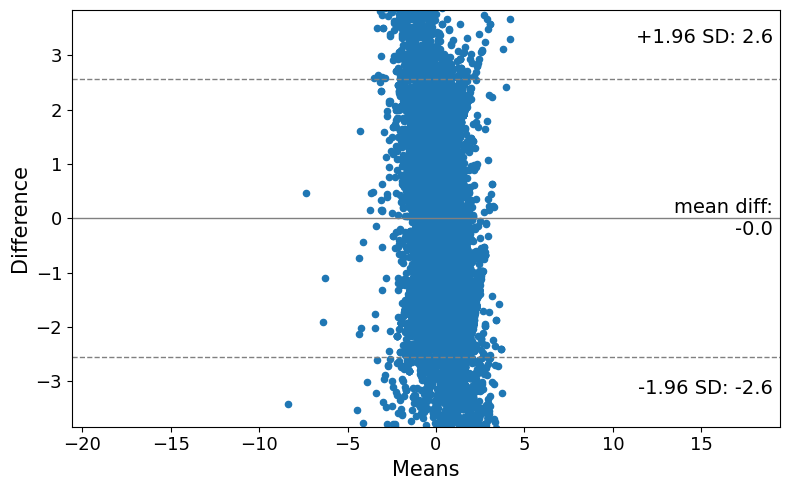

In [10]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(del_spo2_allN, del_SF_allN, ax = ax)

plt.show()

In [12]:
# pip install pyCompare

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


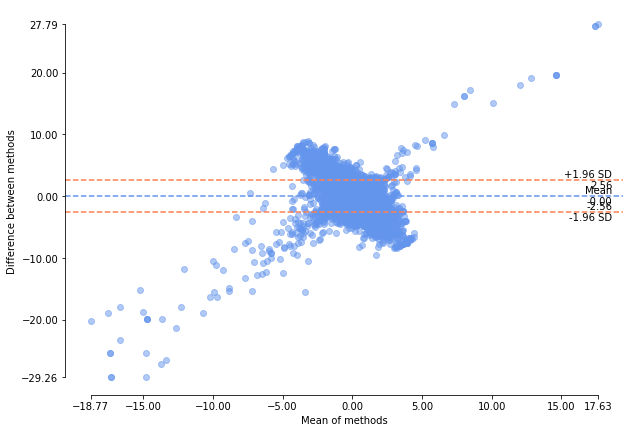

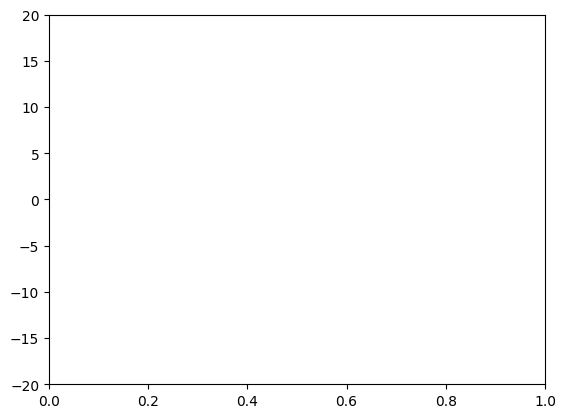

In [20]:
import pyCompare
# pyCompare.blandAltman(del_SF_allN, del_spo2_allN)
plt.Figure()
pyCompare.blandAltman(del_spo2_allN, del_SF_allN)
plt.ylim(-20, 20)
plt.show()

r and p-value are: 0.15020583010363717 0.0


(-20.0, 20.0)

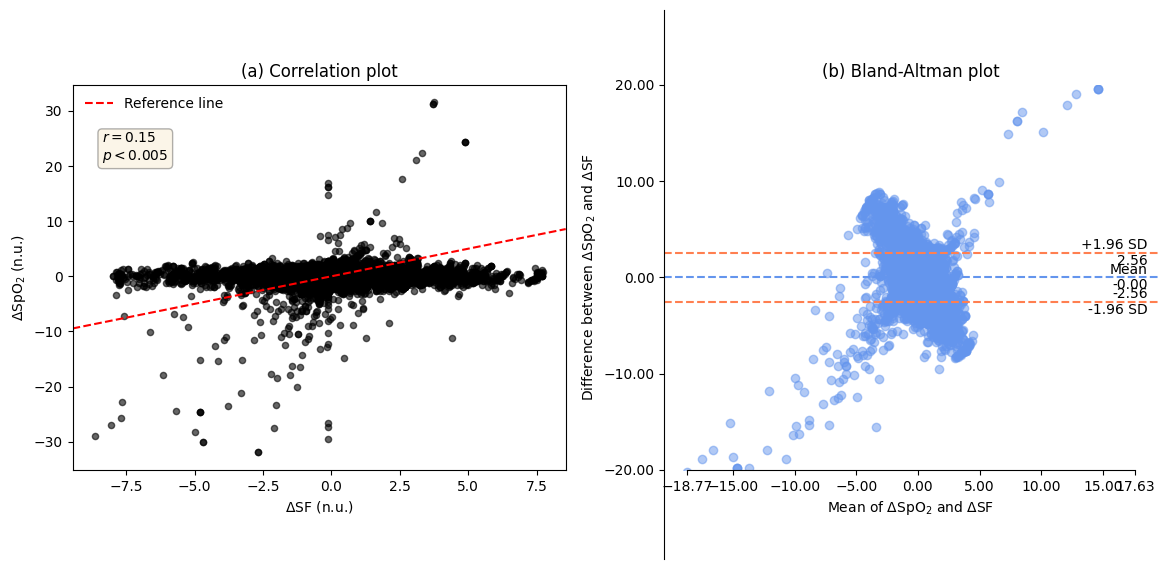

In [23]:
import scipy.stats

fig, axs = plt.subplots(1, 2, figsize =(14, 5))

axs[0].scatter(
     del_SF_allN, del_spo2_allN,
    c='k', s=20, alpha=0.6, marker='o'
)
# Get axis limits
left, right = axs[0].set_xlim()
# Reference line
axs[0].plot([left, right], [left, right], c='r', ls='--', label='Reference line')

r, p = scipy.stats.pearsonr(del_spo2_allN, del_SF_allN)
print(f'r and p-value are:', r, p)

axs[0].legend(frameon=False)
axs[0].set_xlabel('$\Delta$SF (n.u.)')
axs[0].set_ylabel('$\Delta$SpO$_2$ (n.u.)')

textstr = '\n'.join((r'$r=%.2f$' % (r),  r'$p<%.3f$' % (0.005 )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
# place a text box in upper left in axes coords


axs[0].text(0.06, 0.88, textstr, transform=axs[0].transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)
axs[0].set_title('(a) Correlation plot')

pyCompare.blandAltman(del_spo2_allN, del_SF_allN, ax = axs[1])
axs[1].set_xlabel('Mean of $\Delta$SpO$_2$ and $\Delta$SF')
axs[1].set_ylabel('Difference between $\Delta$SpO$_2$ and $\Delta$SF')
axs[1].set_title('(b) Bland-Altman plot')
axs[1].set_ylim(-20, 20)
# axs[1].set_ylim([-25,16])

# plt.savefig('DATA_RESULTS/BlandAltmanEmory_delspo2_and_delSF.tif', dpi=300)

## Find Responders and NonResponders: 

**Responders:** In pre-SF range 1-100, if delta SF>=50, delta SPO2>=1 

**NonResponders:** In pre-SF range >300, if delta SF<=-50 and delta SpO2<=-1

In [ ]:
ind_res = np.array(MSFbaseline_gp1.index)
Responders0 = df_transf.iloc[ind_res]
# Responders0[['deBedTime', 'PAT_ID', 'csn', 'Hb_collection_time', 'Hb', 'MedSPO2_beforeT', 'del_SPO2_3', 'del_Hb_3', 'del_SF_3']]
condi1 = Responders0['del_SF_3'] >= 50 
condi2 = Responders0['del_SPO2_3'] >= 0
Responders = Responders0[condi1 & condi2]
Responders[['deBedTime', 'PAT_ID', 'csn', 'Hb_collection_time', 'Hb', 'MedSPO2_beforeT', 'del_SPO2_3', 'del_Hb_3', 'del_SF_3']]

In [ ]:
# del condi1, condi2
ind_nonres = np.array(MSFbaseline_gp4.index)
NonResponders0 = df_transf.iloc[ind_nonres]
# NonResponders0[['deBedTime', 'PAT_ID', 'csn', 'Hb_collection_time', 'Hb', 'MedSPO2_beforeT', 'del_SPO2_3', 'del_Hb_3', 'del_SF_3']]
condi1 = NonResponders0['del_SF_3'] <= -50 
condi2 = NonResponders0['del_SPO2_3'] <= 0
NonResponders = NonResponders0[condi1 & condi2]
NonResponders[['deBedTime', 'PAT_ID', 'csn', 'Hb_collection_time', 'Hb', 'MedSPO2_beforeT', 'del_SPO2_3', 'del_Hb_3', 'del_SF_3']]

In [ ]:
# ###Saving them in pickle
with open('Data_Transfusion_WaveformAnalysis_9_26_22/RespondersNonresponders.pickle', 'wb') as handle:
    pickle.dump([Responders, NonResponders], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# with open('Data_Transfusion_WaveformAnalysis_9_26_22/RespondersNonresponders.pickle', 'rb') as handle:
#     [Responders1, NonResponders1] = pickle.load(handle)

In [ ]:
# NonResponders1